In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import ParameterGrid

In [2]:
df = pd.read_csv('final_combined_dataset.csv')


In [3]:
from sklearn.preprocessing import LabelEncoder


df['week'] = pd.to_numeric(df['week'], errors='coerce')
df['date'] = pd.to_datetime(df['date'])
# Add date_ordinal
df['date_ordinal'] = df['date'].apply(lambda x: x.toordinal())

# Extract year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Add cyclic month representation
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Add cyclic week representation
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)

df["year_sin"] = np.sin(2 * np.pi * df["year"] / df["year"].max())
df["year_cos"] = np.cos(2 * np.pi * df["year"] / df["year"].max())

# df["cases_rolling_mean"] = df.groupby("geocode")["cases"].transform(lambda x: x.rolling(4).mean())


# Step 2: Create lag features
def create_lags(dataframe, group_col, target_col, lags, inplace = False):
    if isinstance(target_col, list):  # If target_col is a list of columns
        for col in target_col:
            for lag in lags:
                if inplace:
                    dataframe[target_col] = dataframe.groupby(group_col)[col].shift(lag)
                else:
                    dataframe[f'{col}_lag{lag}'] = dataframe.groupby(group_col)[col].shift(lag)
    else:  # If target_col is a single column
        for lag in lags:
            if inplace:
                dataframe[target_col] = dataframe.groupby(group_col)[target_col].shift(lag)
            else:
                dataframe[f'{target_col}_lag{lag}'] = dataframe.groupby(group_col)[target_col].shift(lag)
    return dataframe

# Lag cases by 1 and 2 weeks
data = create_lags(df, group_col='city', target_col='cases', lags=[0,1,-2])

# Lag weather-related variables by 5 and 6 weeks for each city
weather_columns = ['tempe_min', 'temp_avg', 'temp_max', 'humidity_max', 'humidity_avg', 'humidity_min',
                   'precipitation_avg_ordinary_kriging', 'precipitation_max_ordinary_kriging',
                   'precipitation_avg_regression_kriging', 'precipitation_max_regression_kriging']
data = create_lags(df, group_col='city', target_col=weather_columns, lags=[4, 5, 6])
data = data.dropna().reset_index(drop=True)
data['geocode'] = data['geocode'].astype(str)  # Ensure categorical features are in string format

# Now 'transformed_df' contains the transformed data with the correct types
train_data = data[data['date'].dt.year <= 2020]
test_data = data[data['date'].dt.year >= 2021]
pd.set_option('display.max_columns', None)

X_train = train_data.drop(columns=['cases','cases_per_100k','cases_lag-2'])
y_train = train_data[['cases_lag-2']]

X_test = test_data.drop(columns=['cases','cases_per_100k','cases_lag-2'])
y_test = test_data[['cases_lag-2']]



In [4]:
X_test

date    week  population  tempe_min  humidity_max  humidity_avg  \
464   2021-01-03  202101      207044  20.571429     93.220059     71.354385   
465   2021-01-10  202102      207044  21.857143     94.056203     74.070766   
466   2021-01-17  202103      207044  22.285714     85.551194     58.037205   
467   2021-01-24  202104      207044  21.285714     86.385208     55.524891   
468   2021-01-31  202105      207044  21.000000     92.613150     75.049454   
...          ...     ...         ...        ...           ...           ...   
51501 2022-11-13  202246      273988  20.857143     90.883001     79.522168   
51502 2022-11-20  202247      273988  20.714286     93.280477     82.167320   
51503 2022-11-27  202248      273988  21.857143     95.875069     82.840922   
51504 2022-12-04  202249      273988  21.857143     92.543531     80.151192   
51505 2022-12-11  202250      273988  21.000000     94.213747     79.480439   

       humidity_min   temp_avg   temp_max            city  geocode       vim  \
464       51.797334  26.159341  31.142857  angra dos reis  3300100  0.855700   
465       56.106602  26.469388  30.857143  angra dos reis  3300100  0.857531   
466       42.041434  28.803768  32.857143  angra dos reis  3300100  0.859299   
467       38.248368  29.108494  33.714286  angra dos reis  3300100  0.860919   
468       56.072542  25.506279  30.428571  angra dos reis  3300100  0.862375   
...             ...        ...        ...             ...      ...       ...   
51501     61.268456  23.714286  27.857143   volta redonda  3306305  0.645087   
51502     67.014975  23.726190  27.000000   volta redonda  3306305  0.664894   
51503     61.313170  25.507143  30.857143   volta redonda  3306305  0.683798   
51504     64.110460  24.903139  28.142857   volta redonda  3306305  0.701526   
51505     59.964030  24.597222  28.500000   volta redonda  3306305  0.717158   

       vim_monthly  precipitation_avg_ordinary_kriging  \
464       0.858233                              3.4918   
465       0.858233                              4.1258   
466       0.858233                              0.0000   
467       0.858233                              0.0000   
468       0.858233                              5.1522   
...            ...                                 ...   
51501     0.642000                              2.2254   
51502     0.642000                              3.2501   
51503     0.642000                              4.9788   
51504     0.716900                              1.8253   
51505     0.716900                              3.2077   

       precipitation_max_ordinary_kriging  \
464                               14.5038   
465                               11.5154   
466                                1.0099   
467                                0.0000   
468                               23.7147   
...                                   ...   
51501                              9.5493   
51502                             15.0136   
51503                             17.2846   
51504                              8.1846   
51505                             13.9077   

       precipitation_avg_regression_kriging  \
464                                  2.8288   
465                                  1.6147   
466                                  0.0000   
467                                  0.0025   
468                                  3.6285   
...                                     ...   
51501                                2.1986   
51502                                3.3057   
51503                                4.8787   
51504                                1.9016   
51505                                3.6355   

       precipitation_max_regression_kriging       long        lat  \
464                                 14.1979 -44.319627 -23.009116   
465                                  9.1777 -44.319627 -23.009116   
466                                  0.3171 -44.319627 -23.009116   
467                    

C:\Users\user\AppData\Local\Temp\ipykernel_19800\295998359.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[numeric_features] = feature_scaler.transform(X_test[numeric_features])


Fitting 3 folds for each of 20 candidates, totalling 60 fits
0:	learn: 0.0147557	total: 163ms	remaining: 1m 21s
100:	learn: 0.0025605	total: 2.67s	remaining: 10.6s
200:	learn: 0.0017950	total: 5.12s	remaining: 7.62s
300:	learn: 0.0015143	total: 7.59s	remaining: 5.02s
400:	learn: 0.0013594	total: 9.96s	remaining: 2.46s
499:	learn: 0.0012432	total: 12.4s	remaining: 0us
Best Parameters: {'verbose': 100, 'random_strength': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 500, 'early_stopping_rounds': 100, 'depth': 4, 'border_count': 128, 'boosting_type': 'Plain', 'bagging_temperature': 0}

CatBoost Model Performance:
CatBoost RMSE (Train): 18.392746735919754
CatBoost RMSE (Test): 6.044942577596639
CatBoost R² (Train): 0.9936116871658869
CatBoost R² (Test): 0.8506606035473735


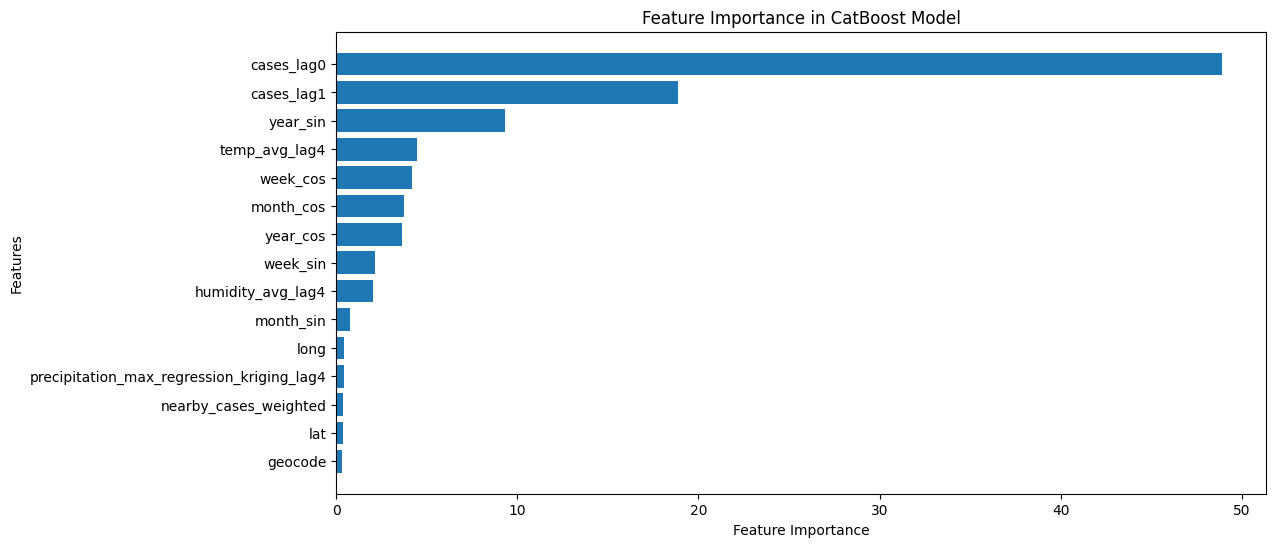

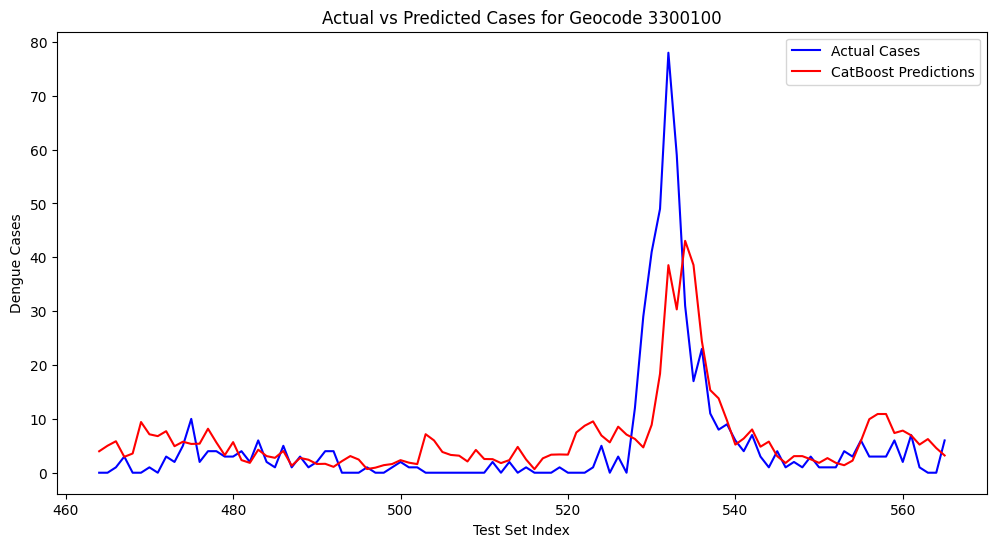

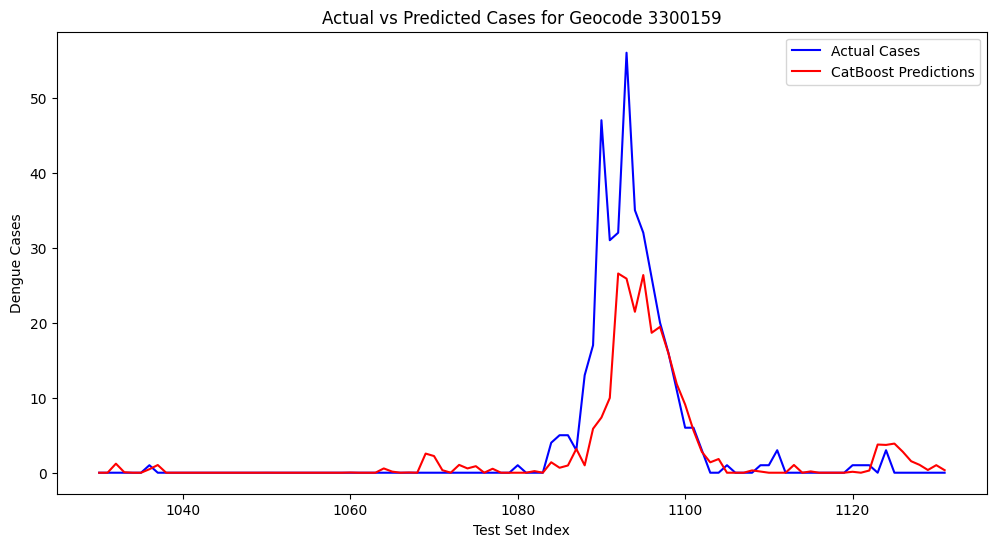

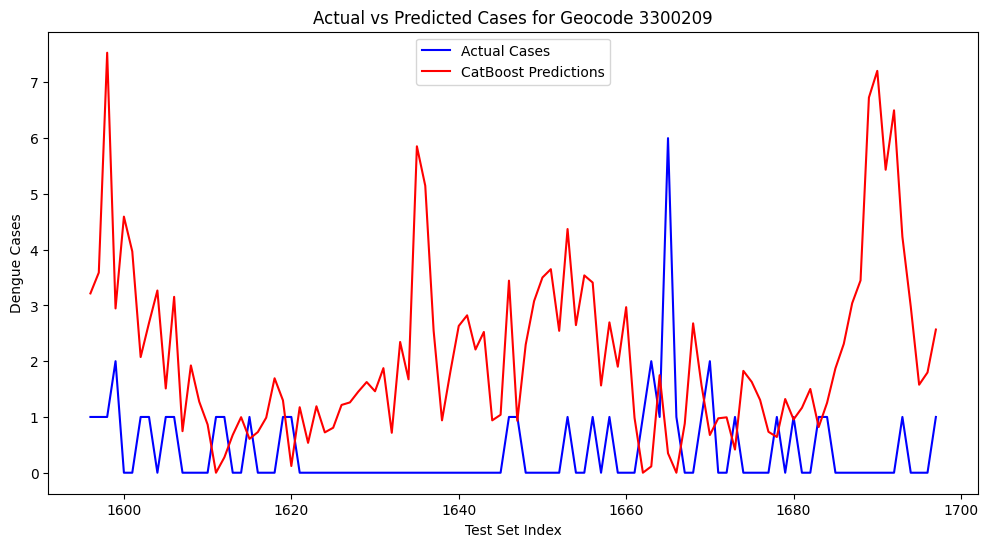

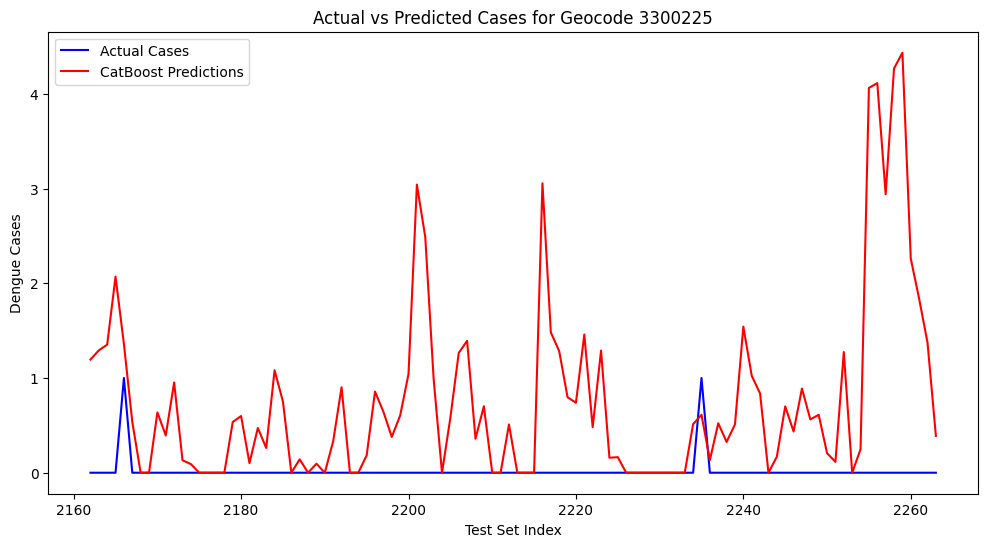

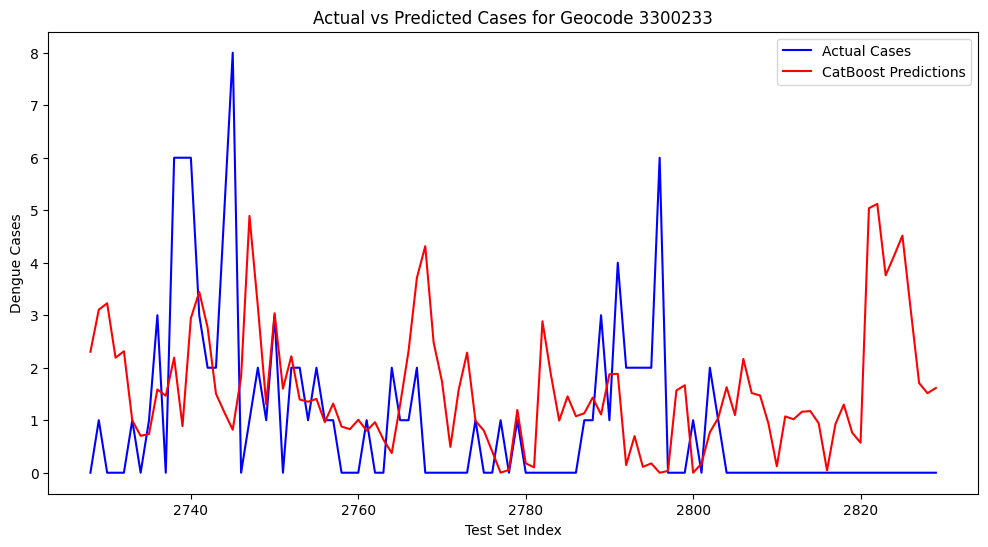

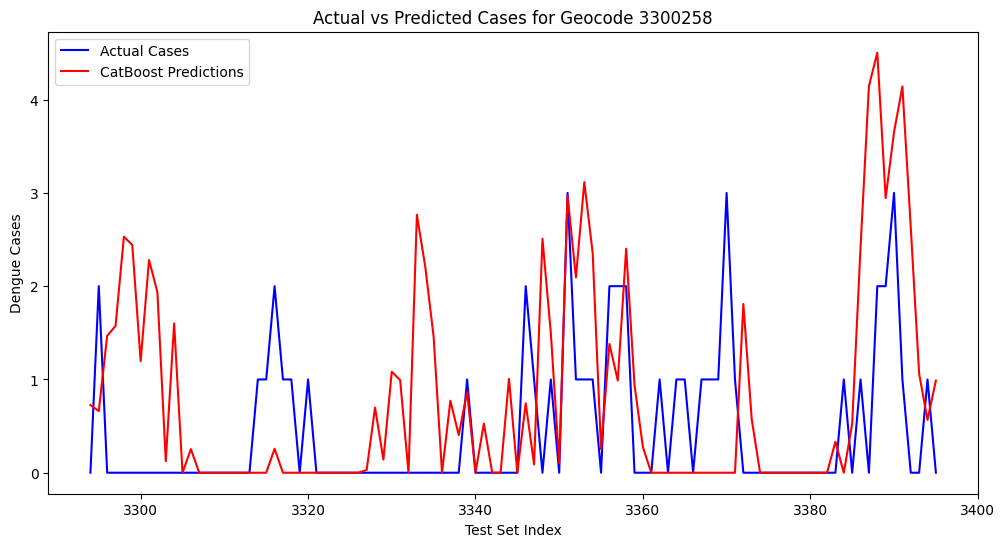

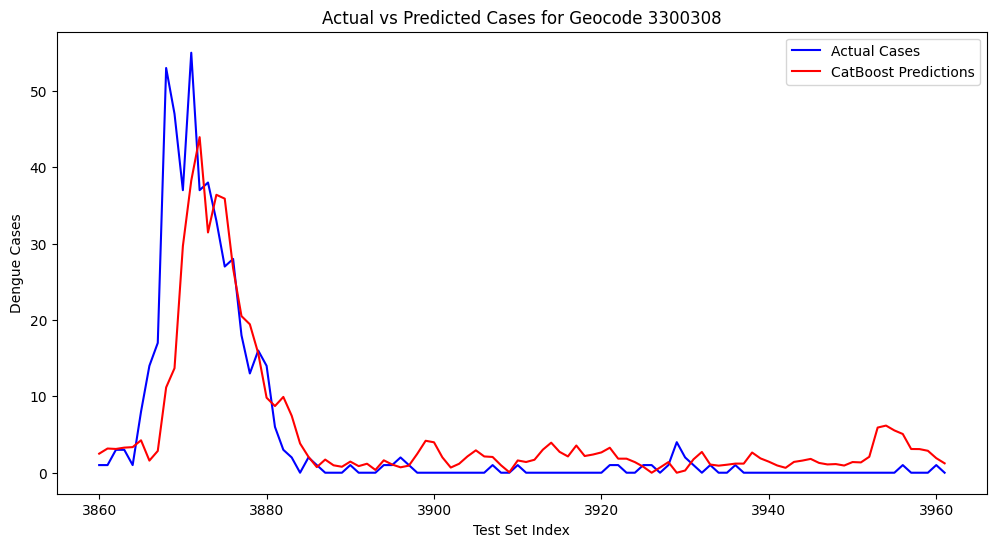

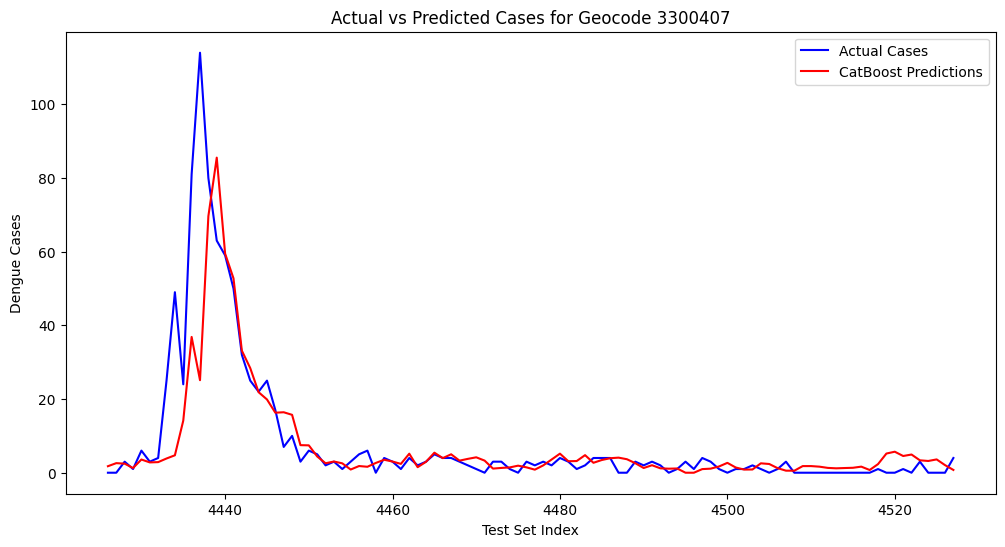

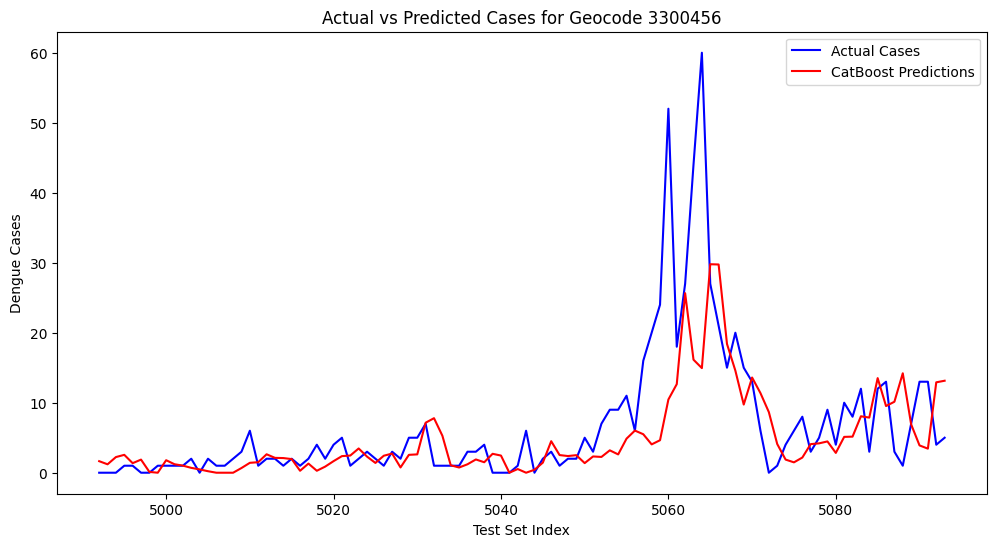

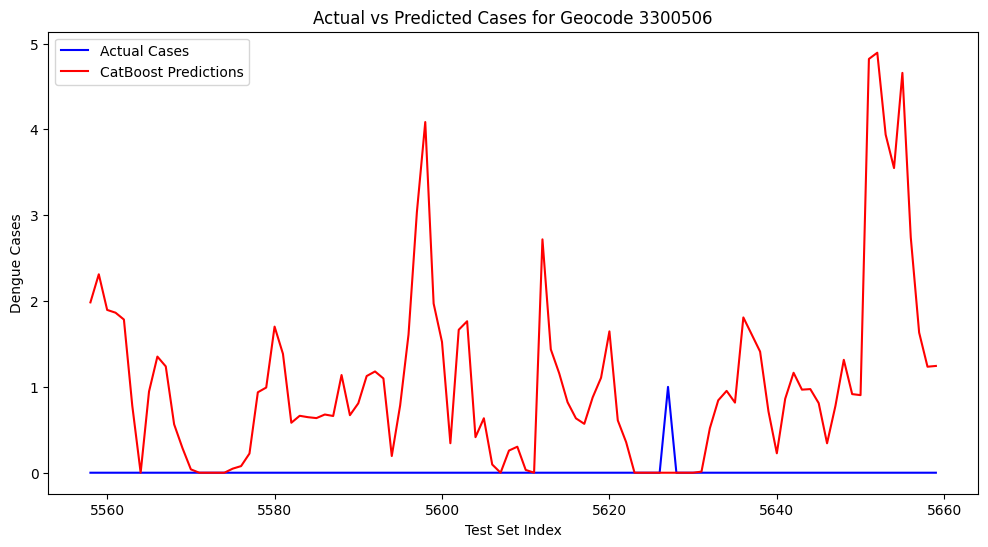

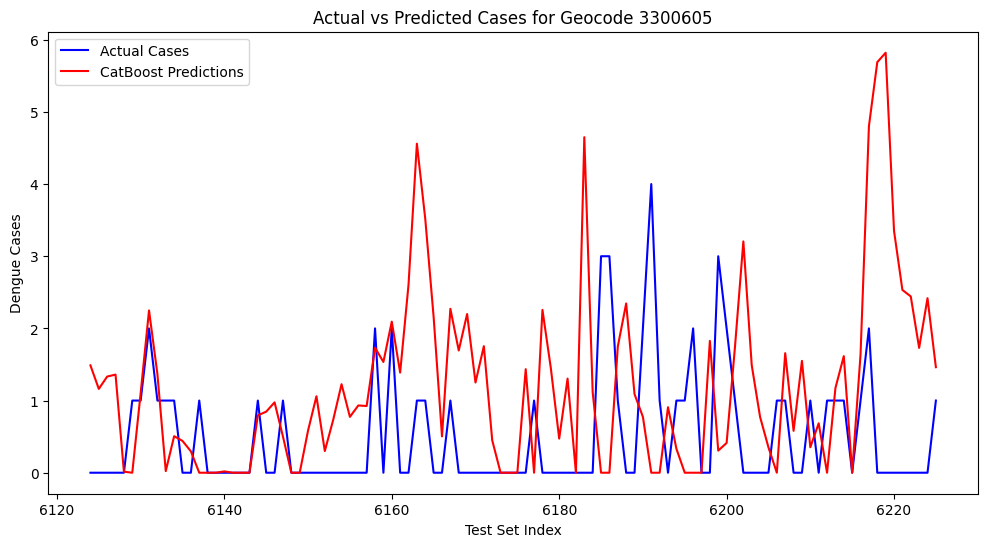

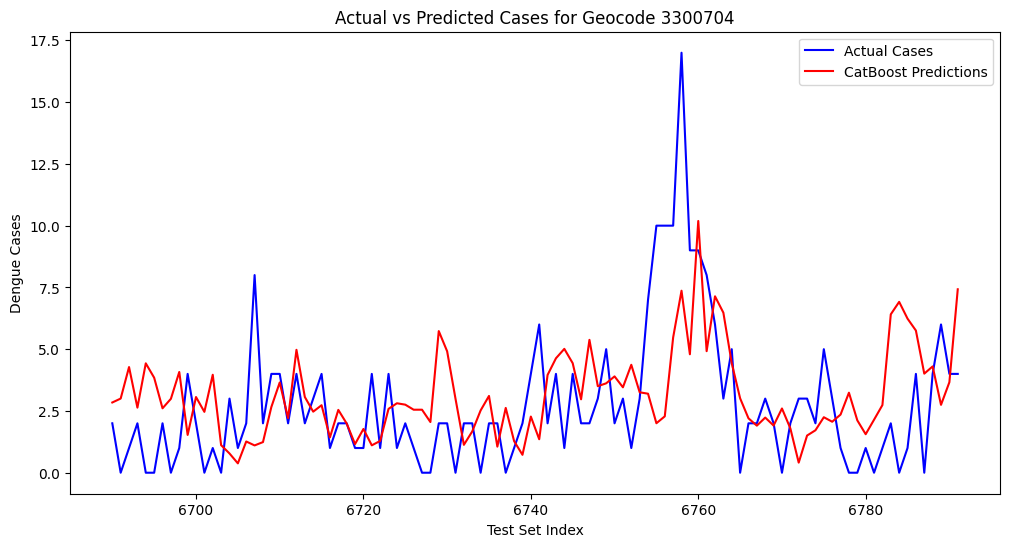

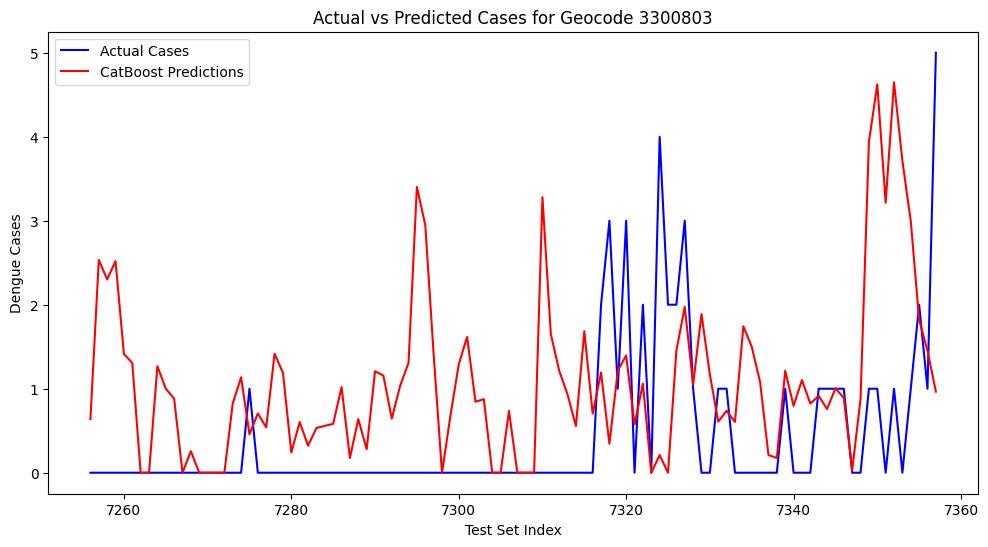

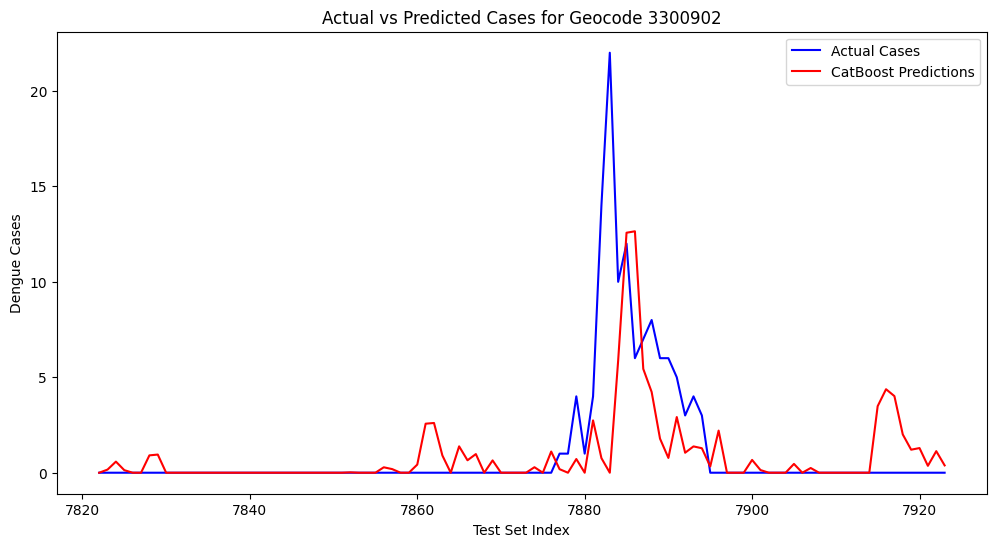

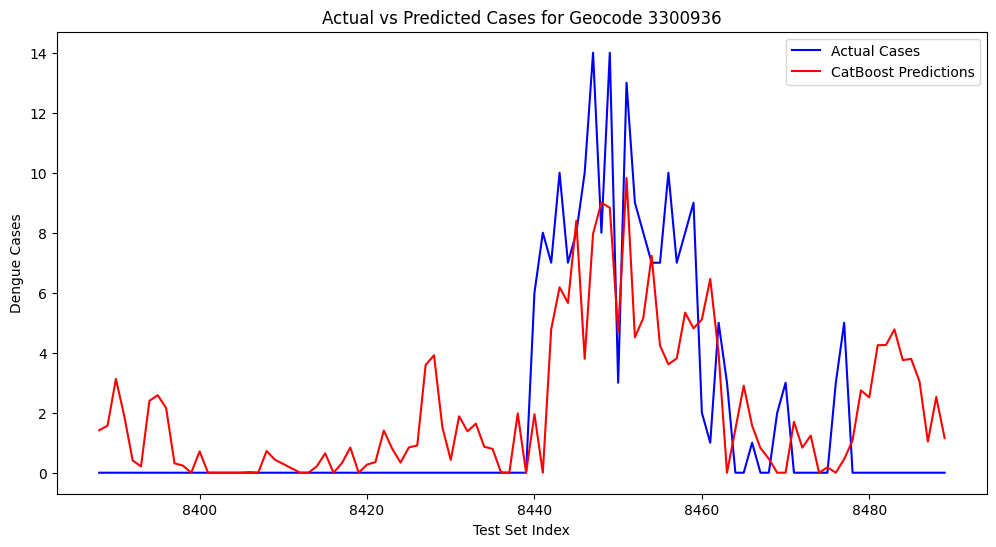

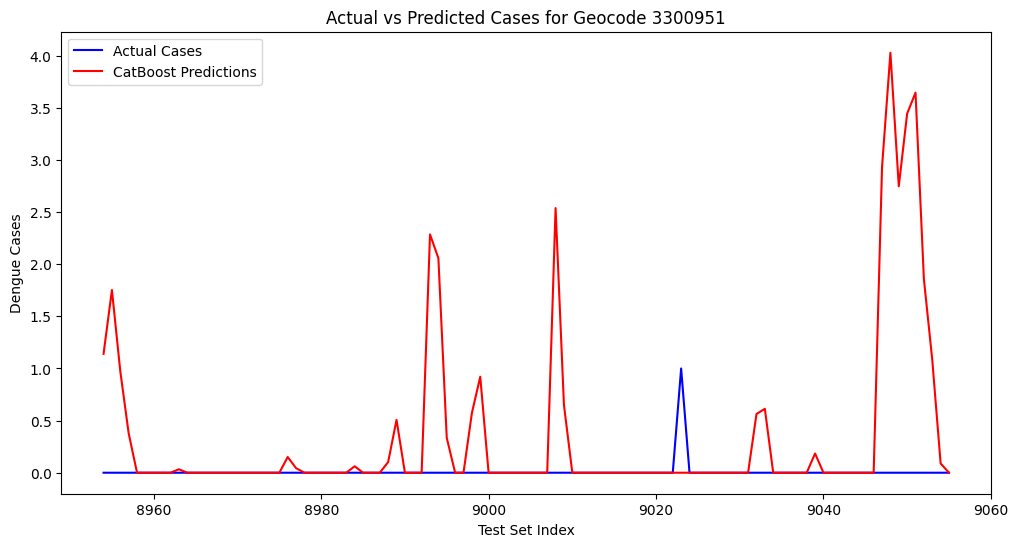

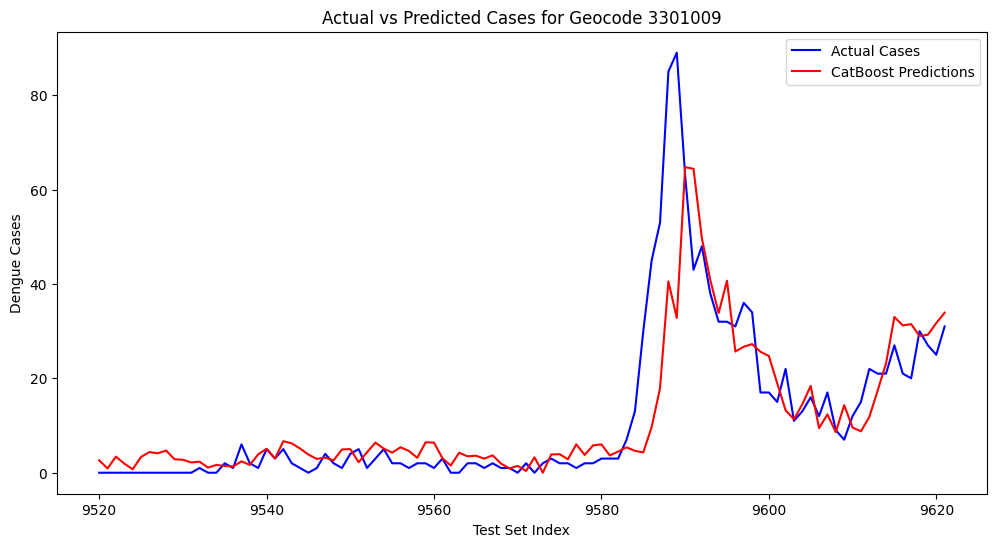

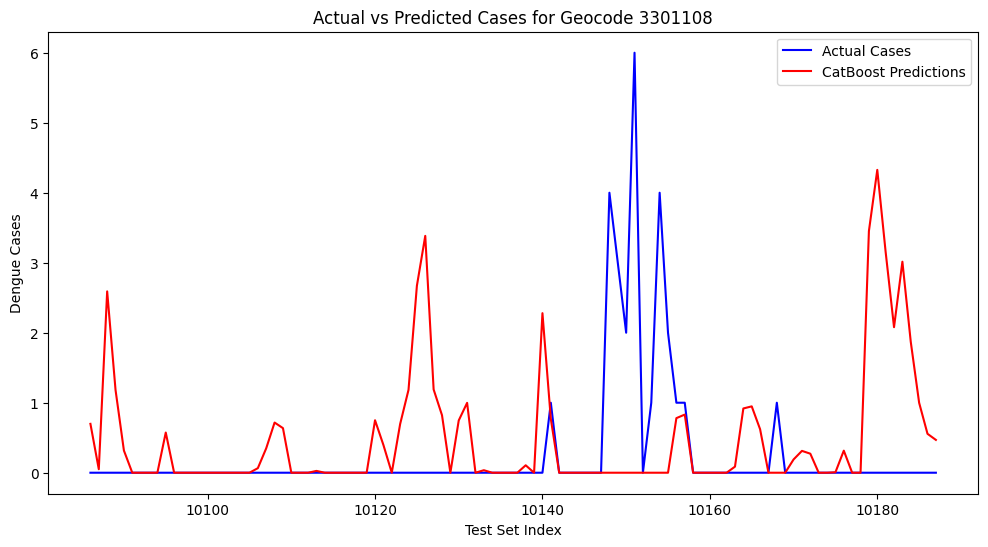

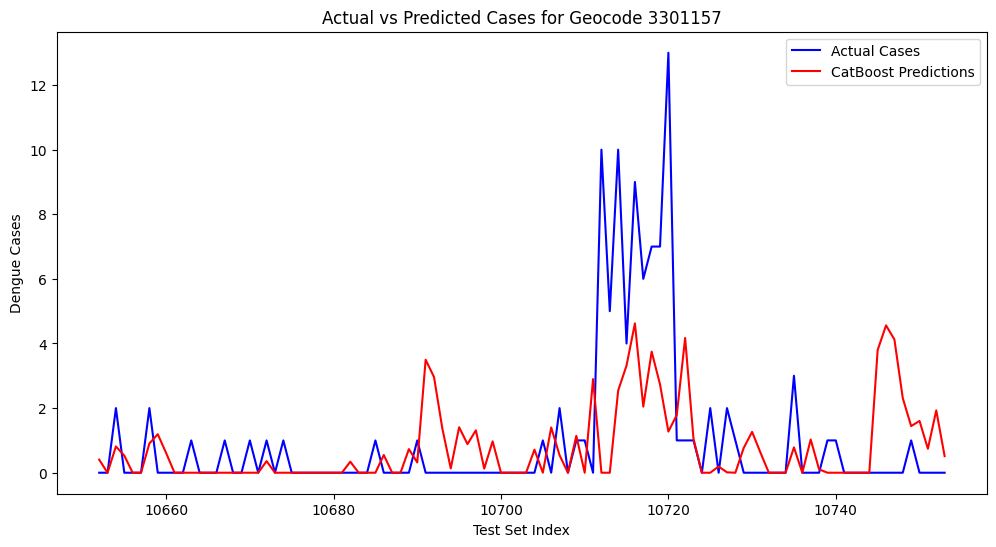

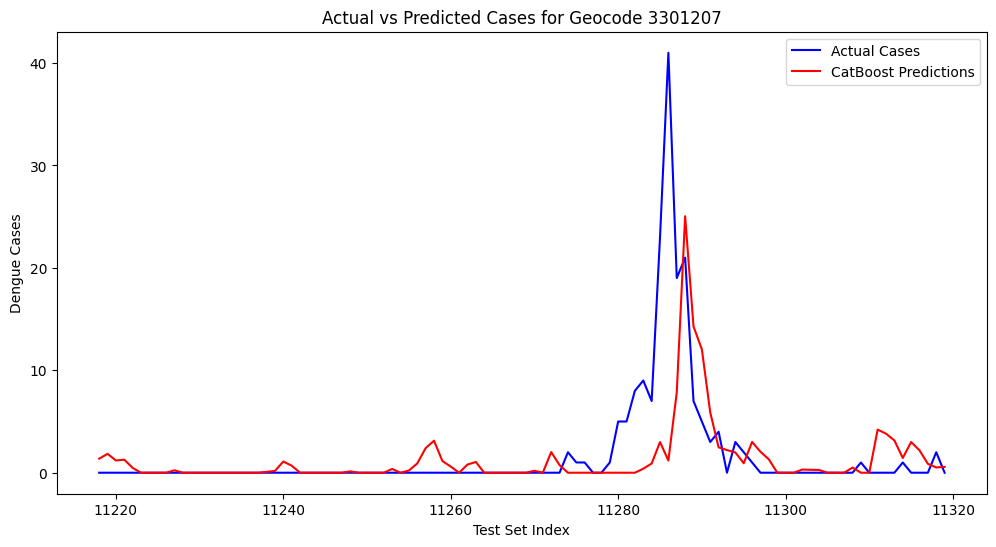

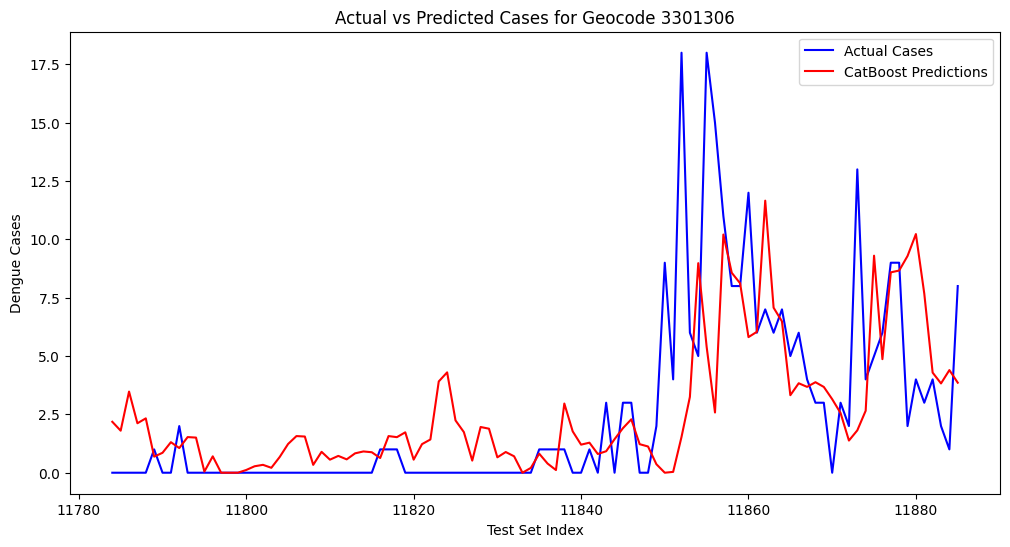

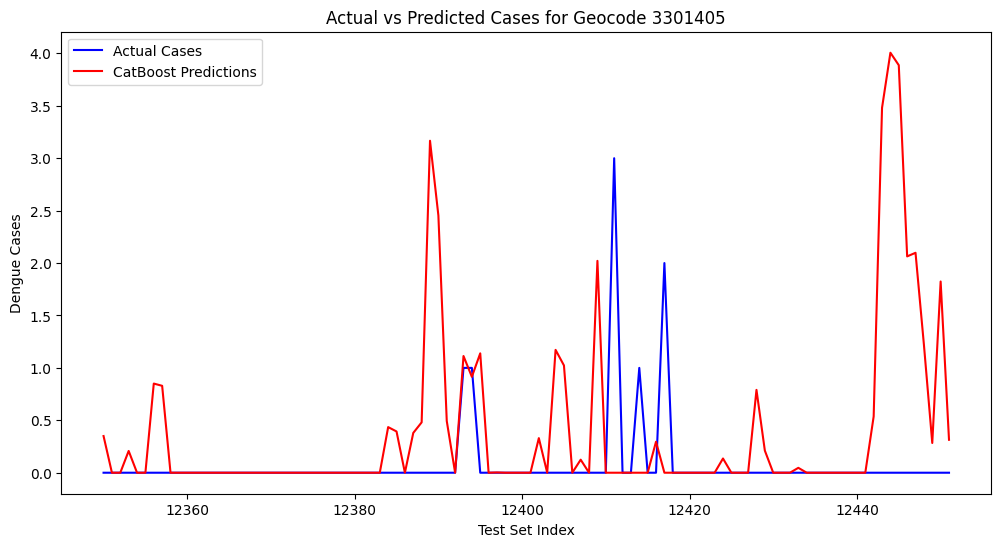

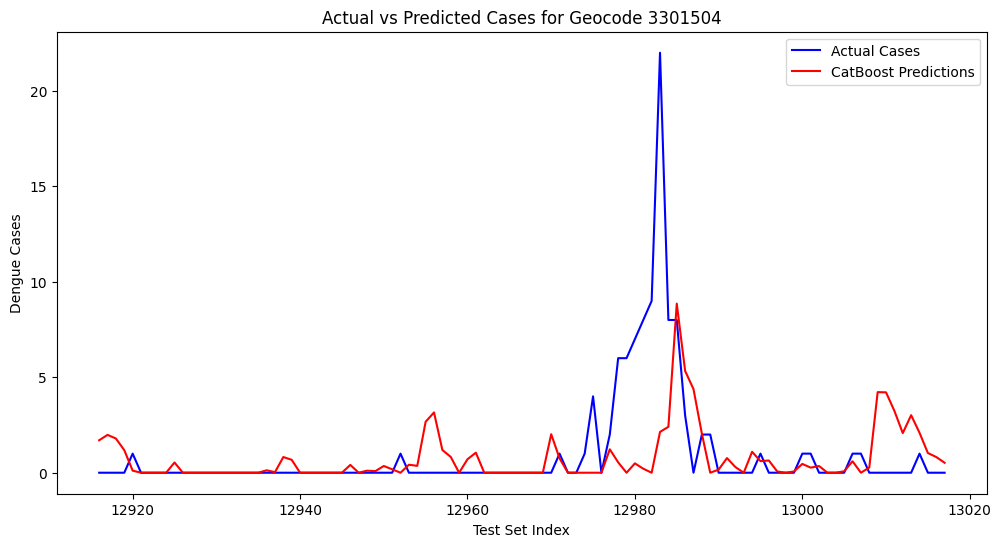

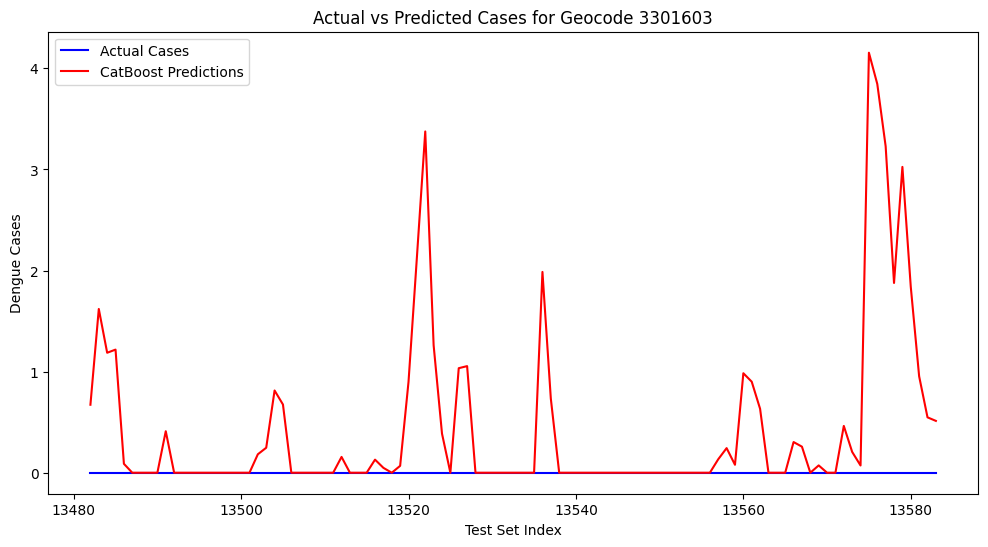

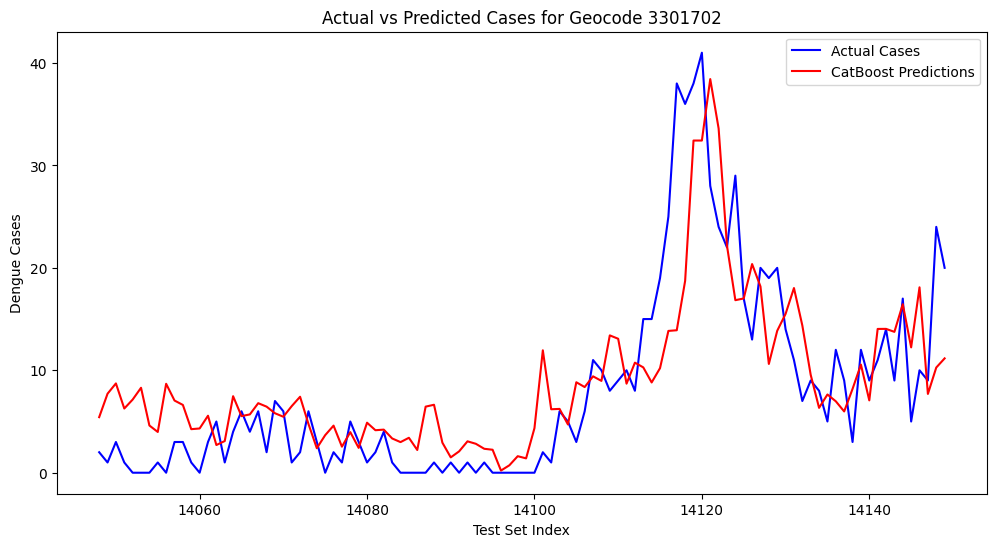

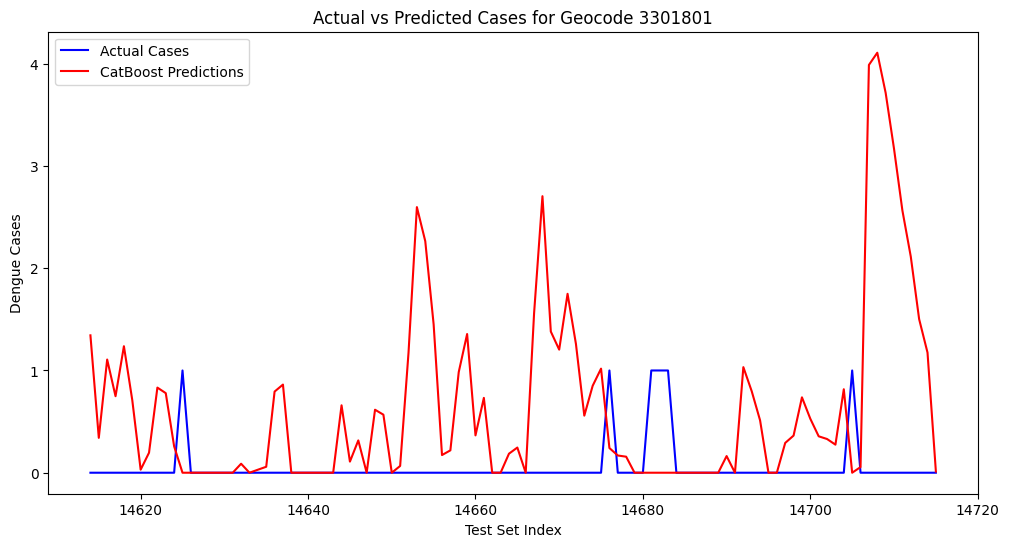

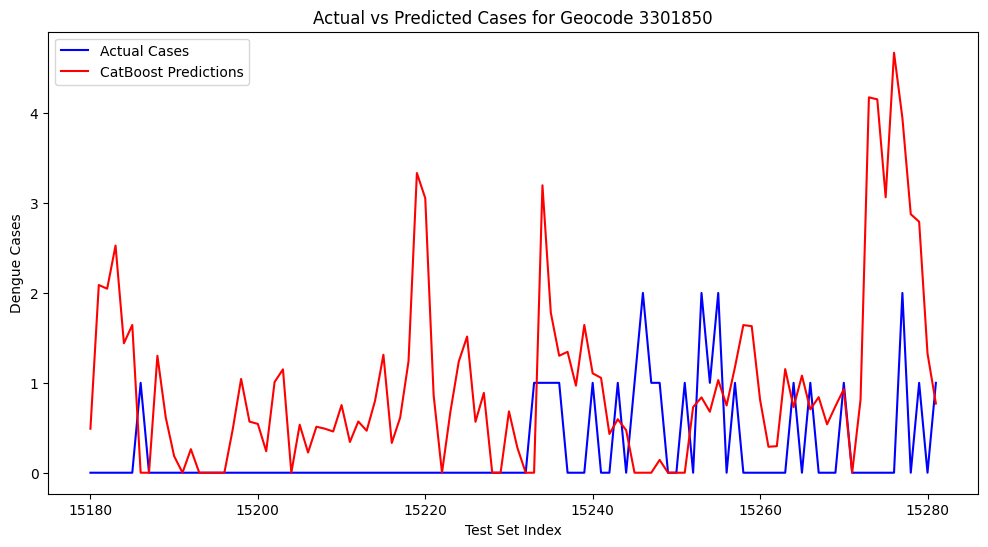

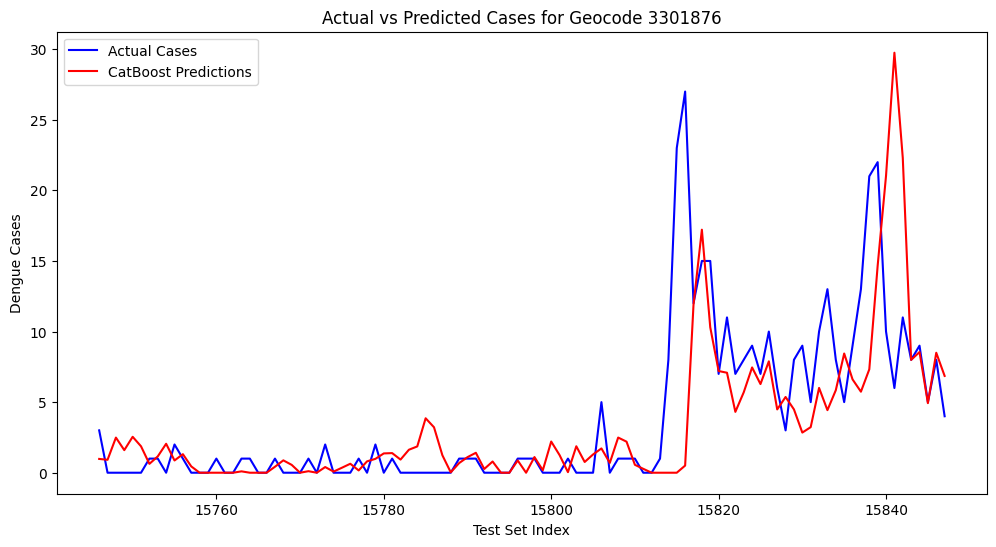

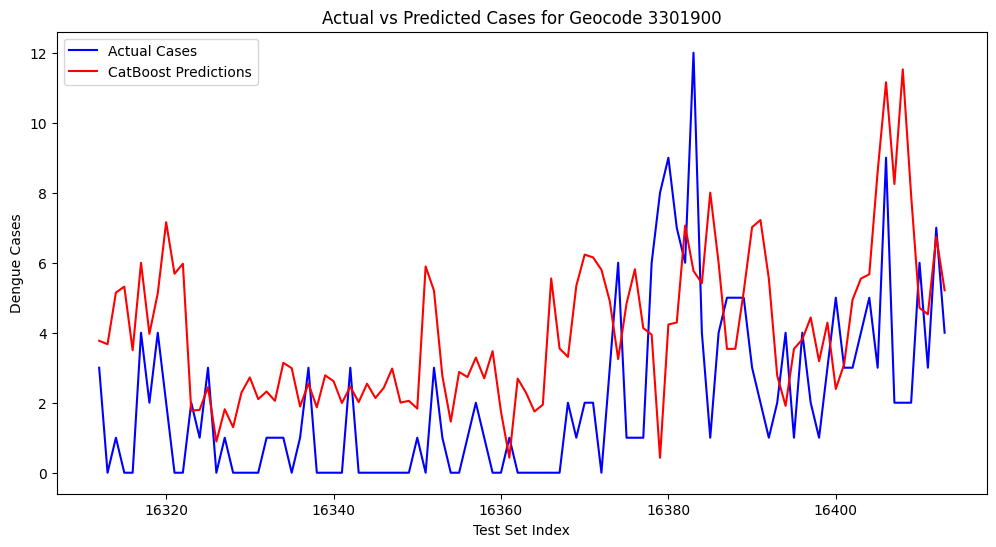

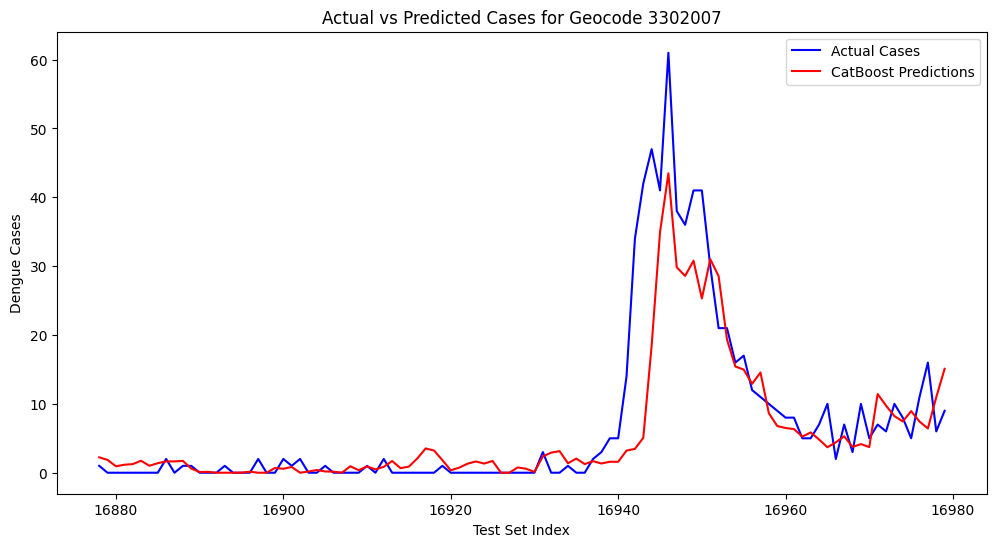

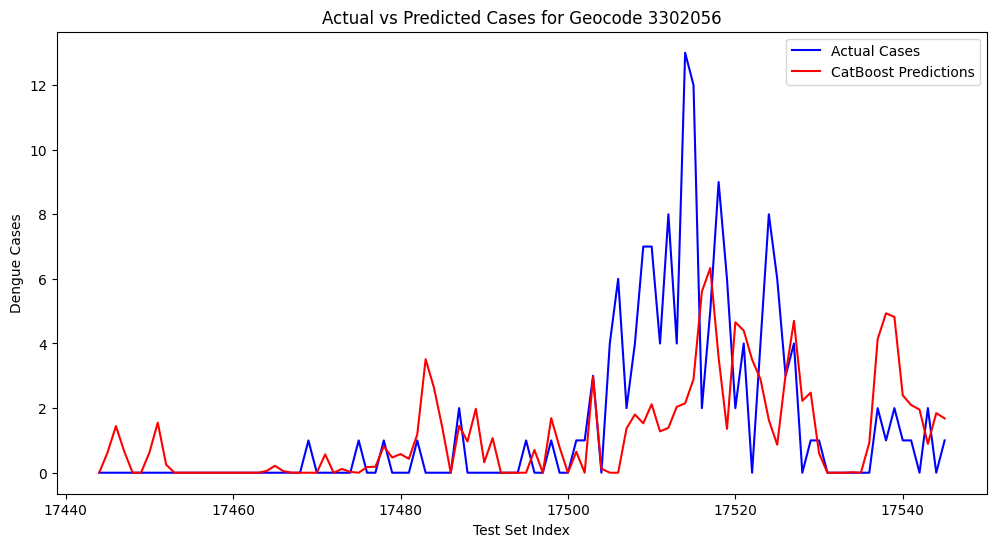

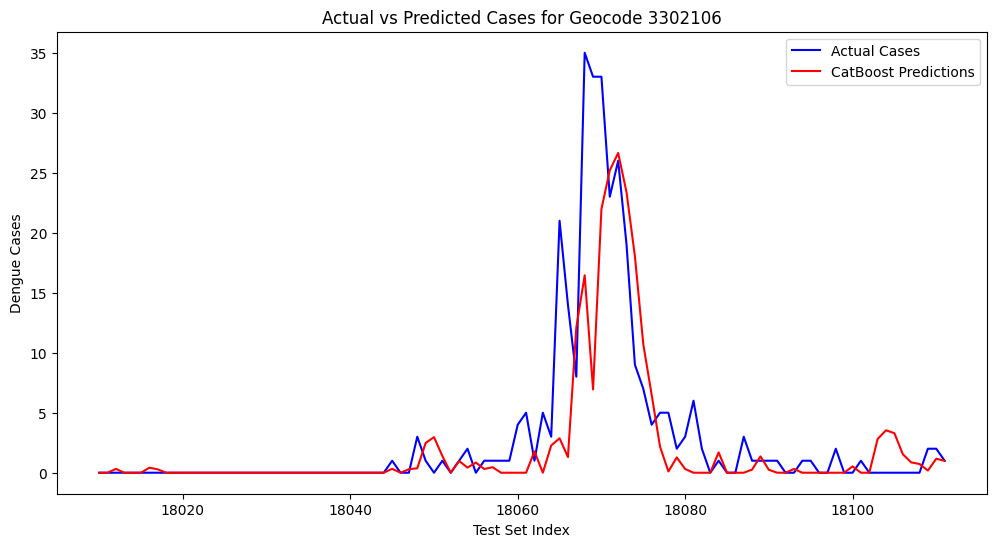

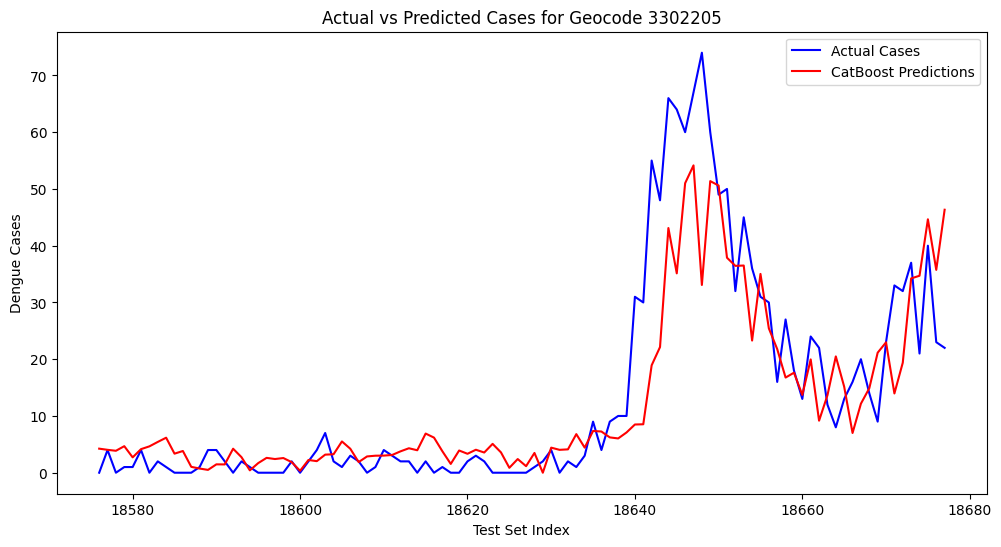

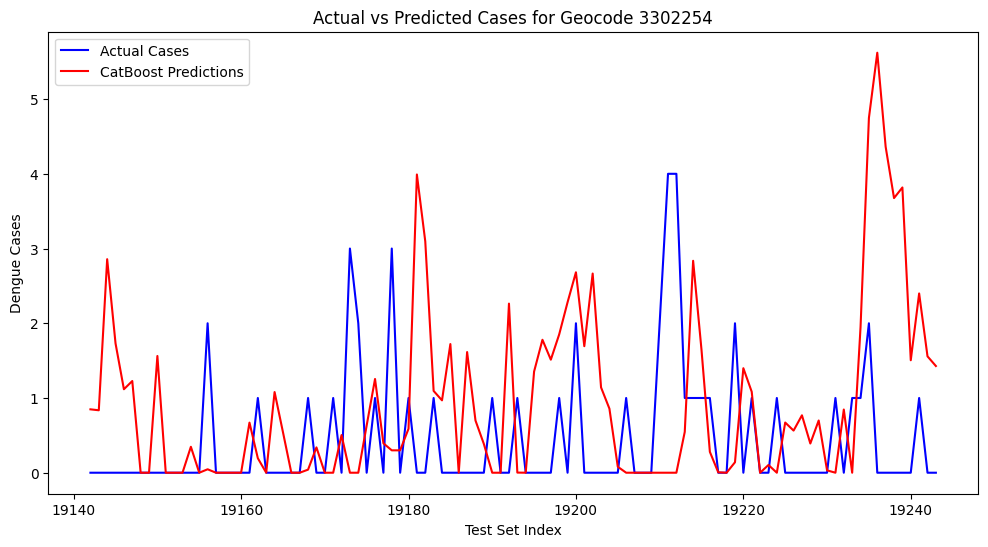

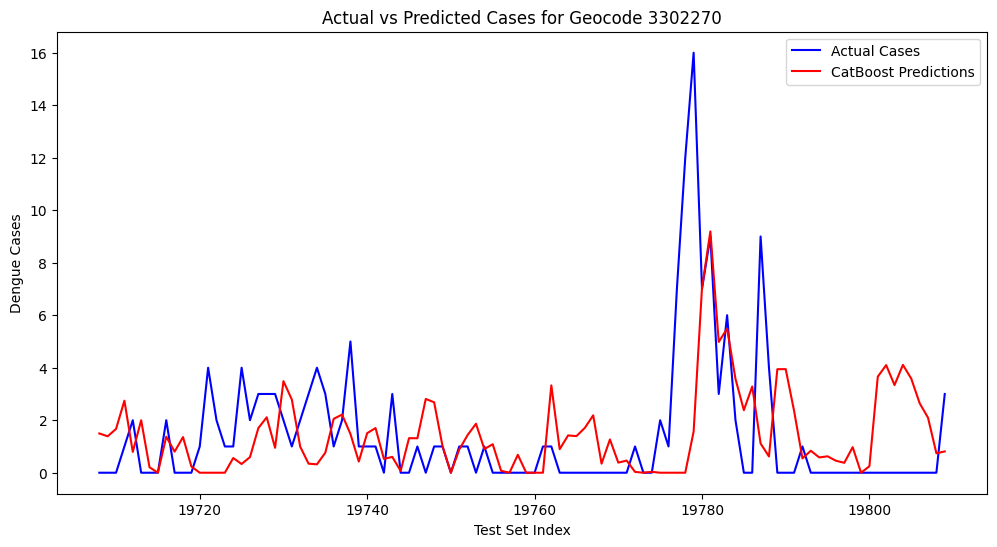

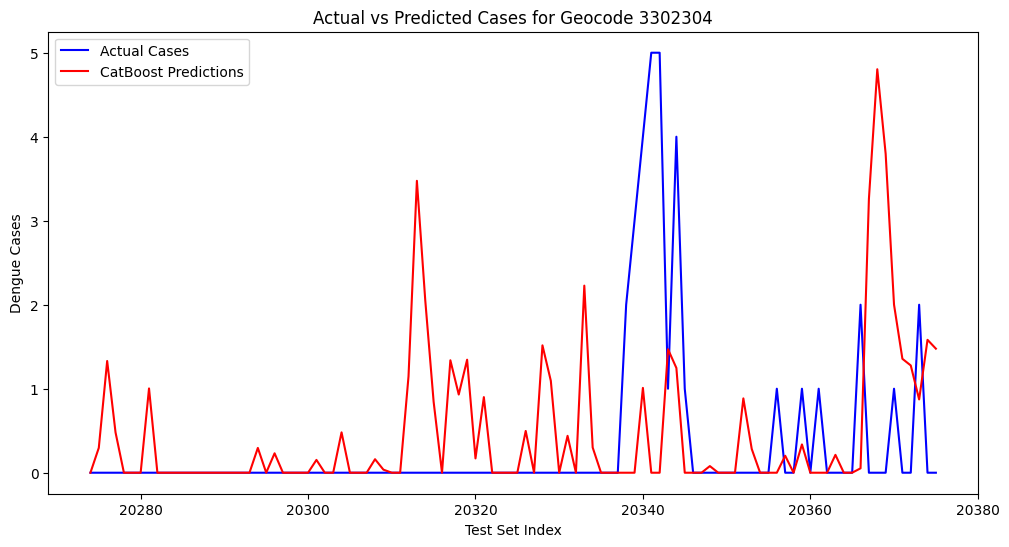

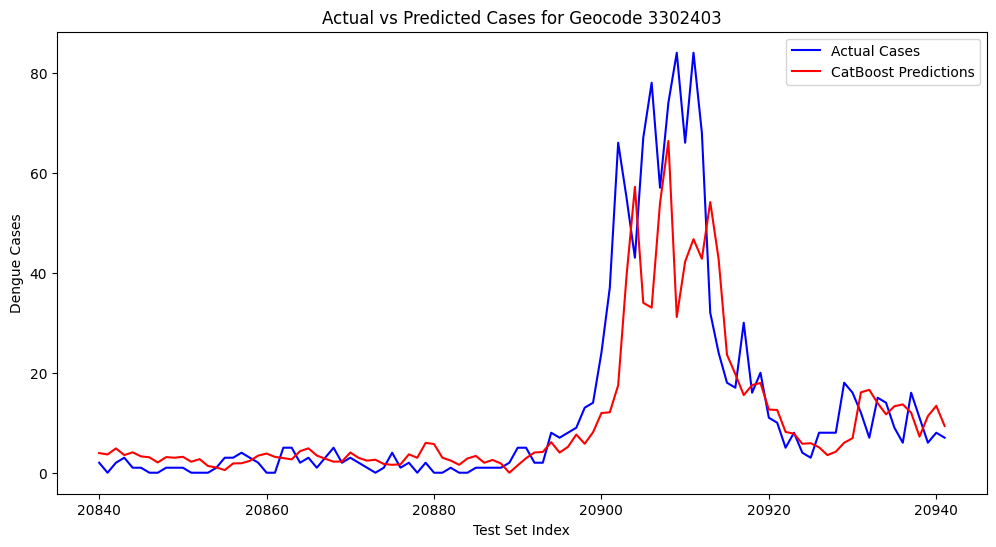

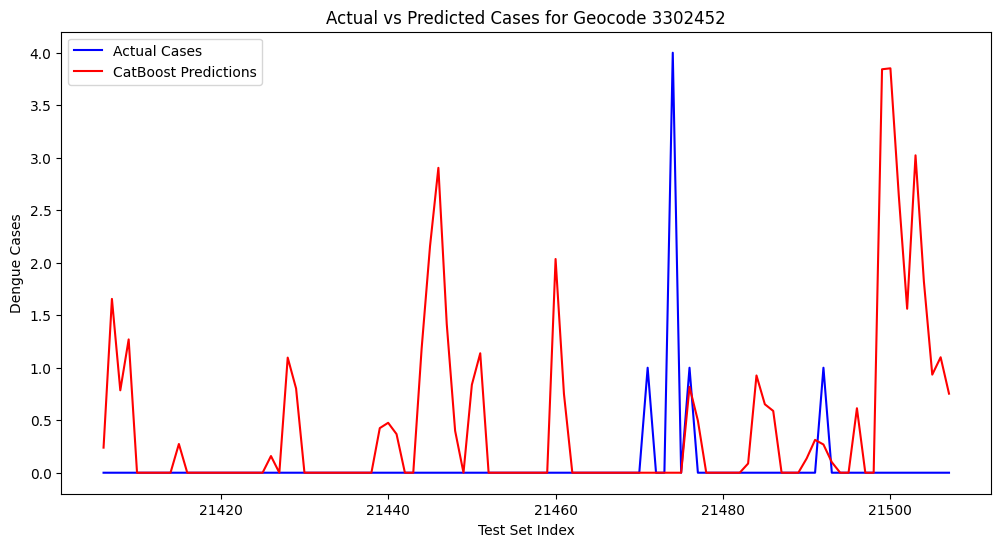

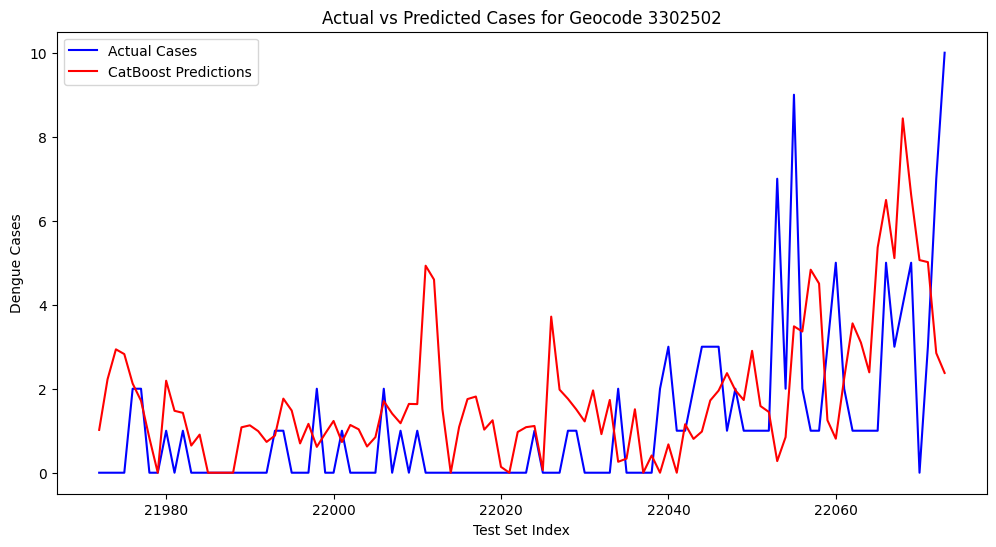

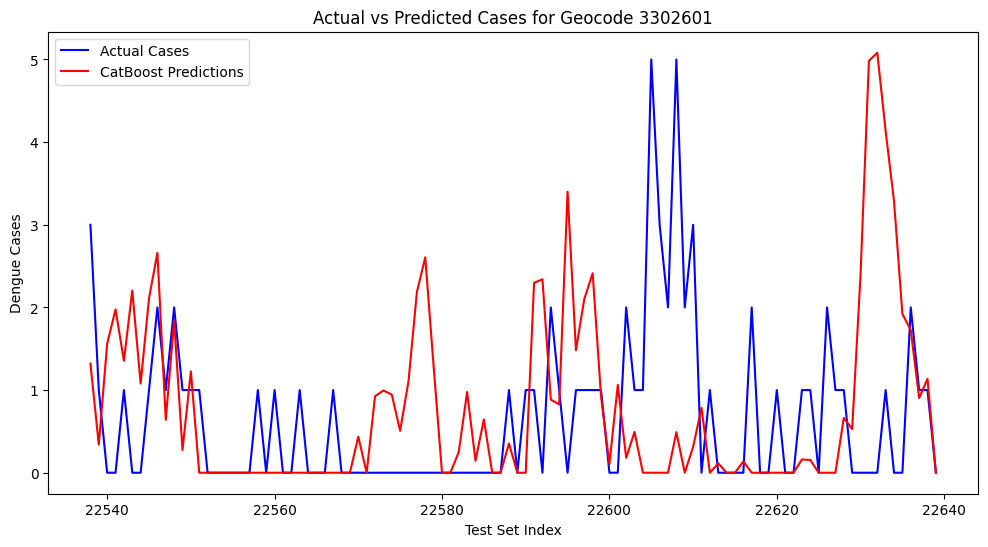

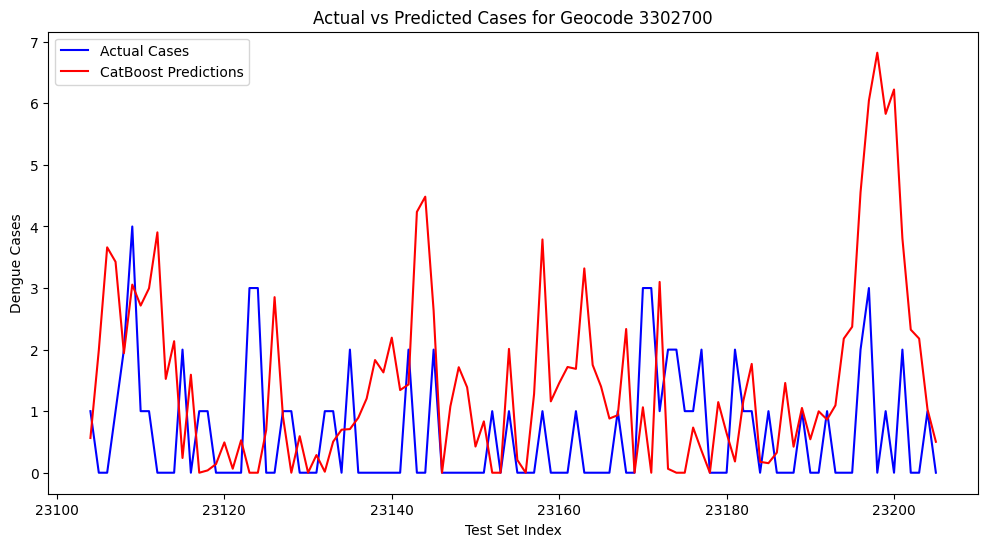

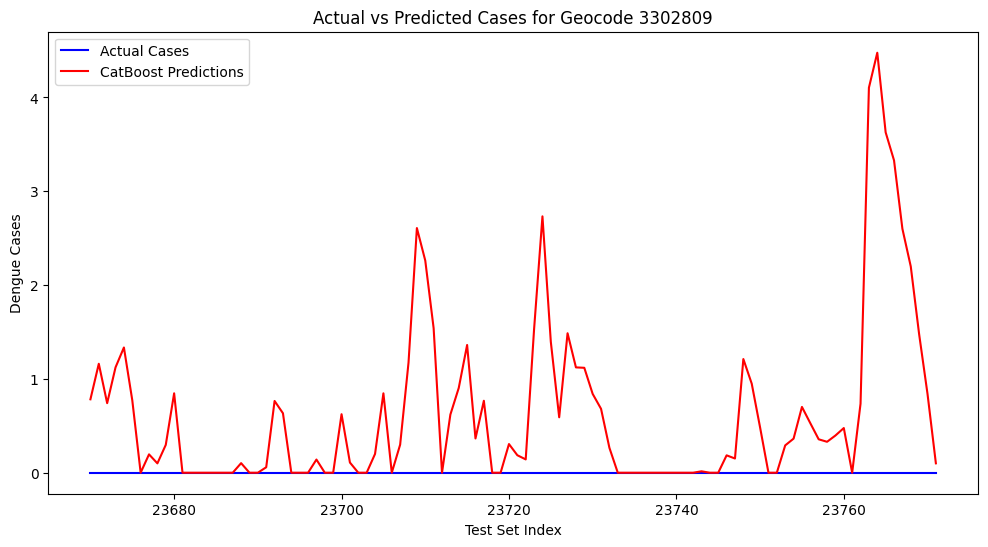

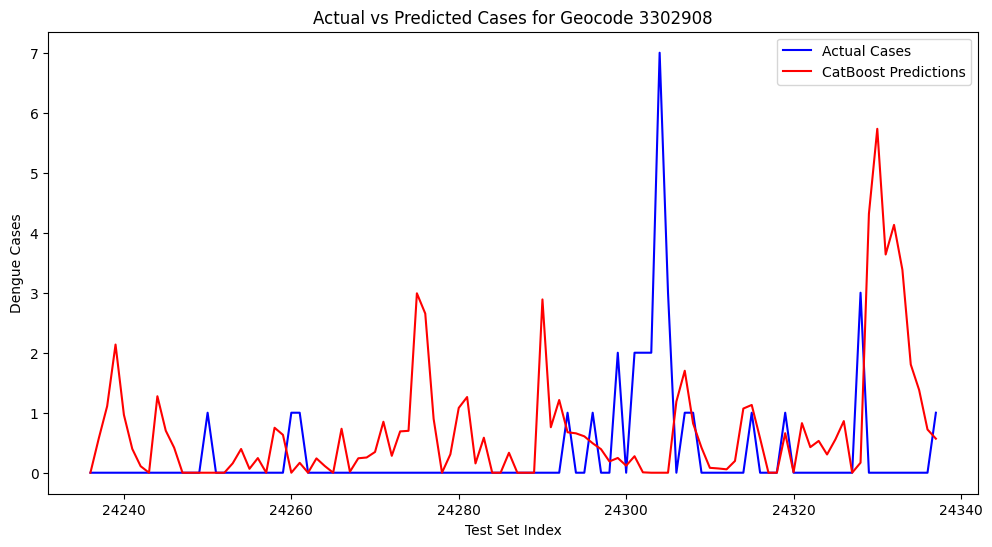

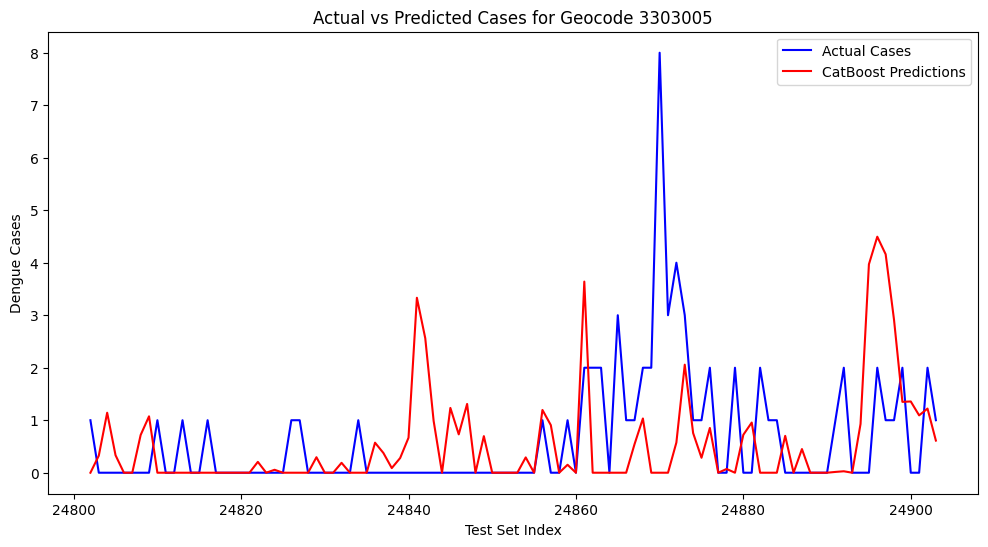

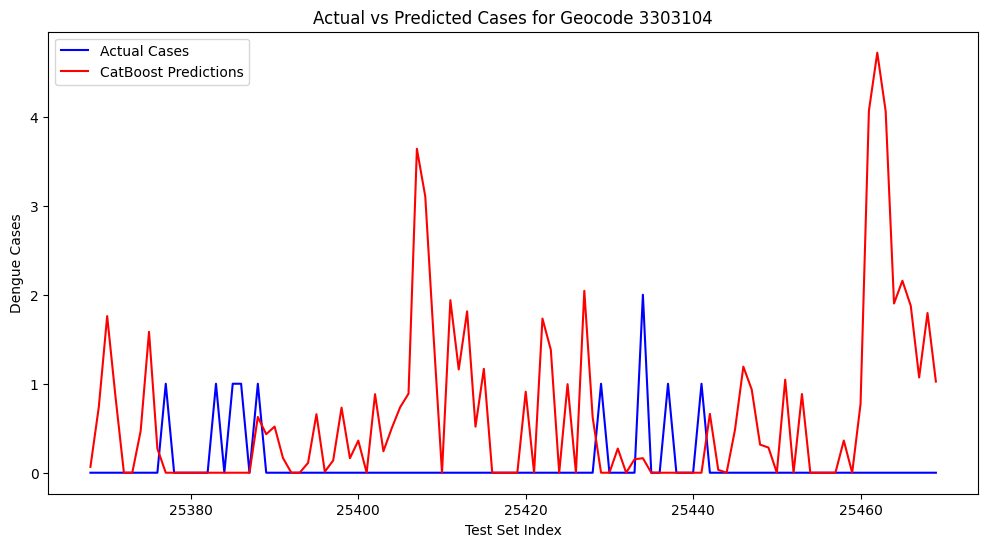

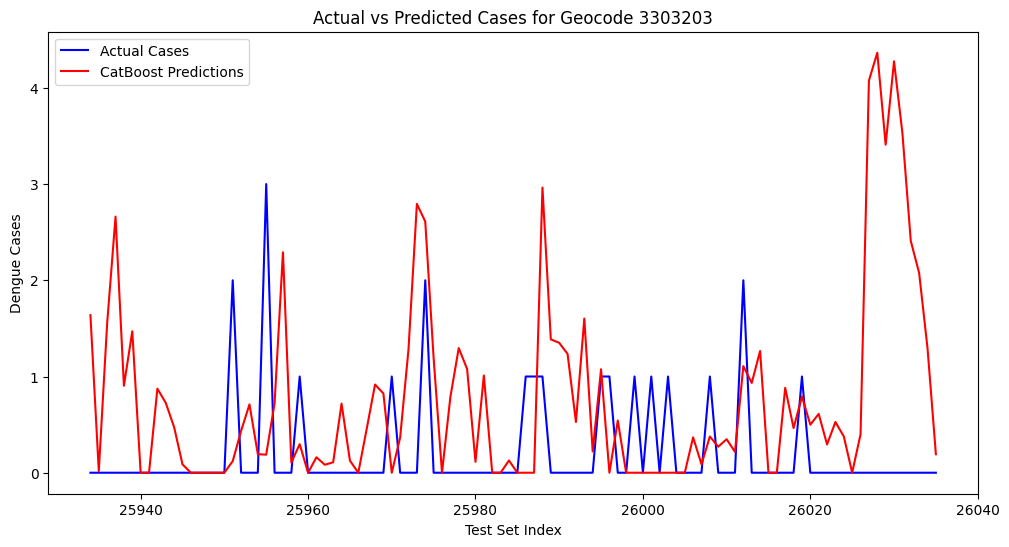

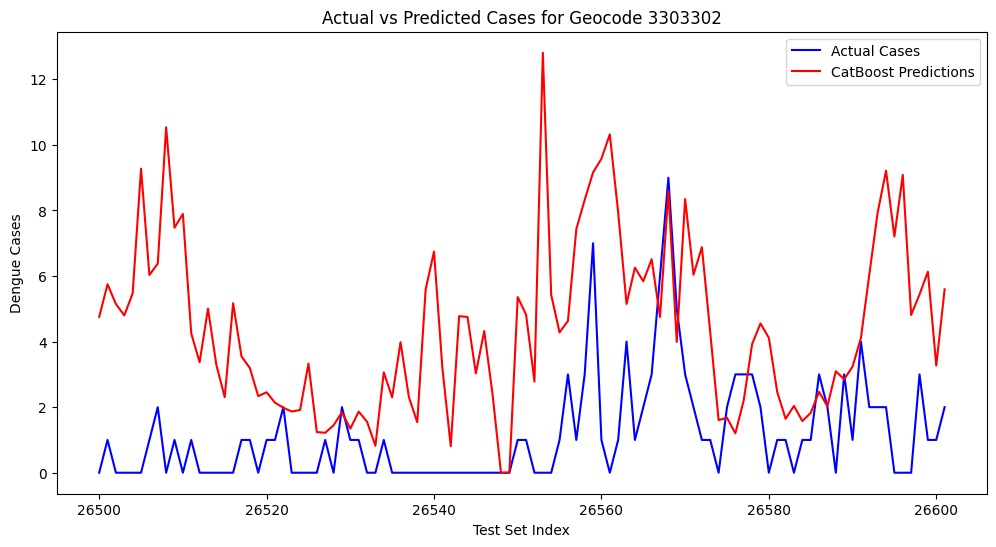

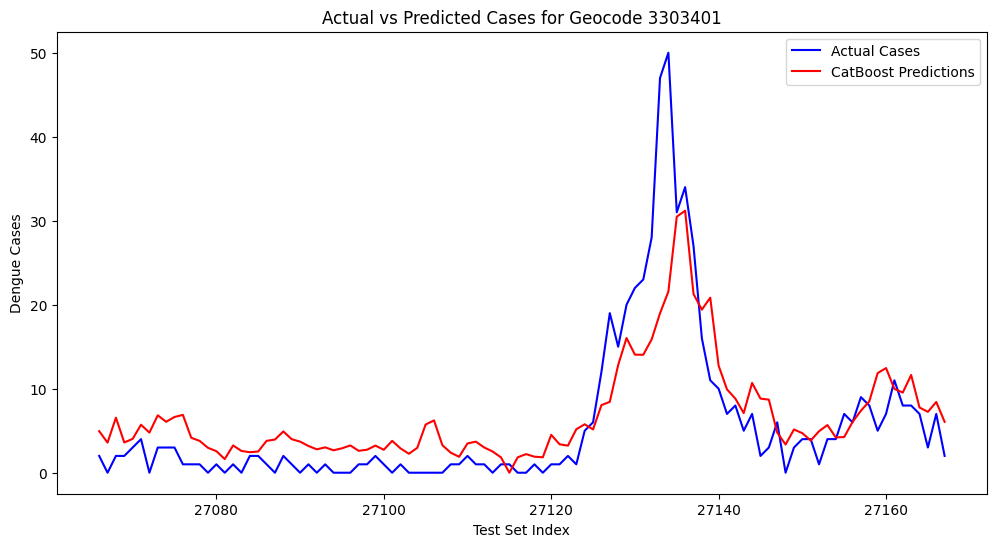

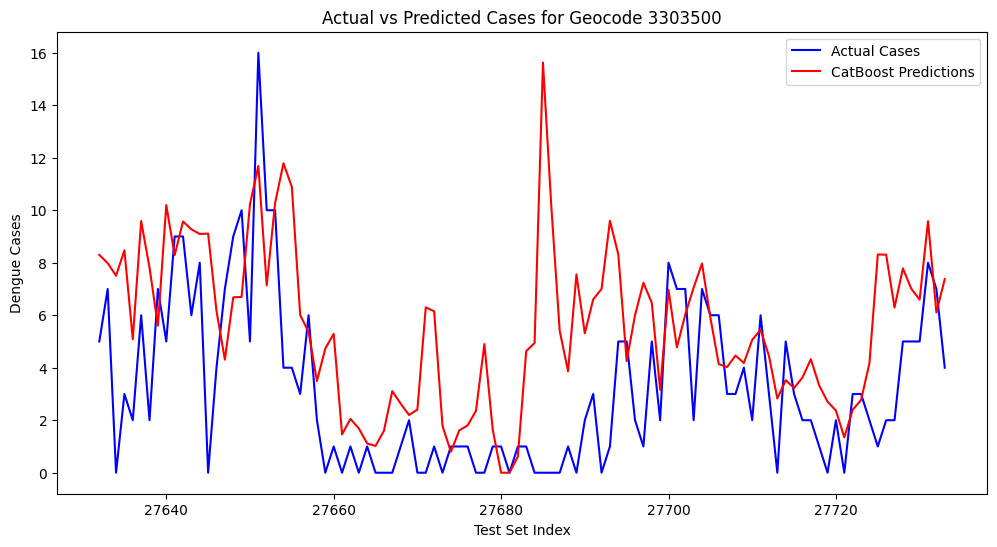

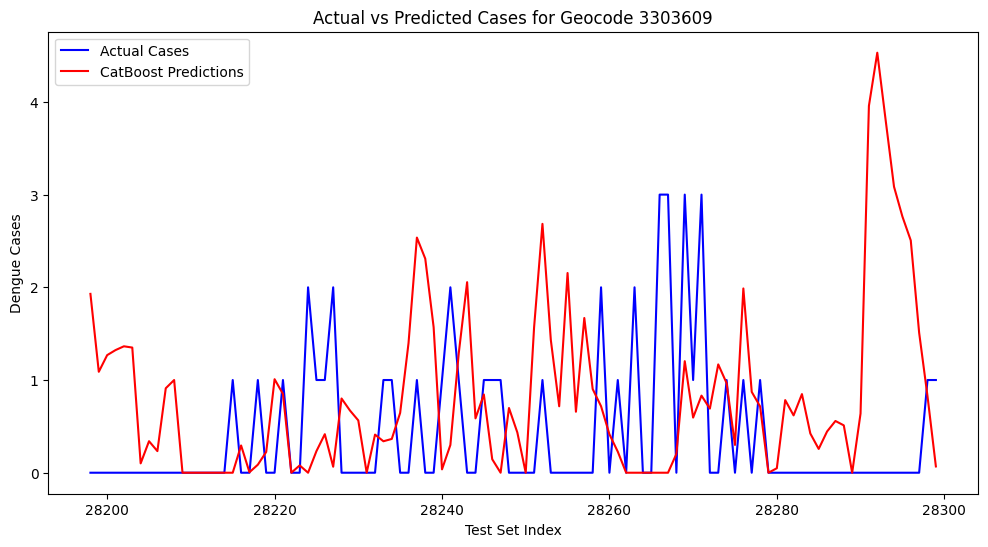

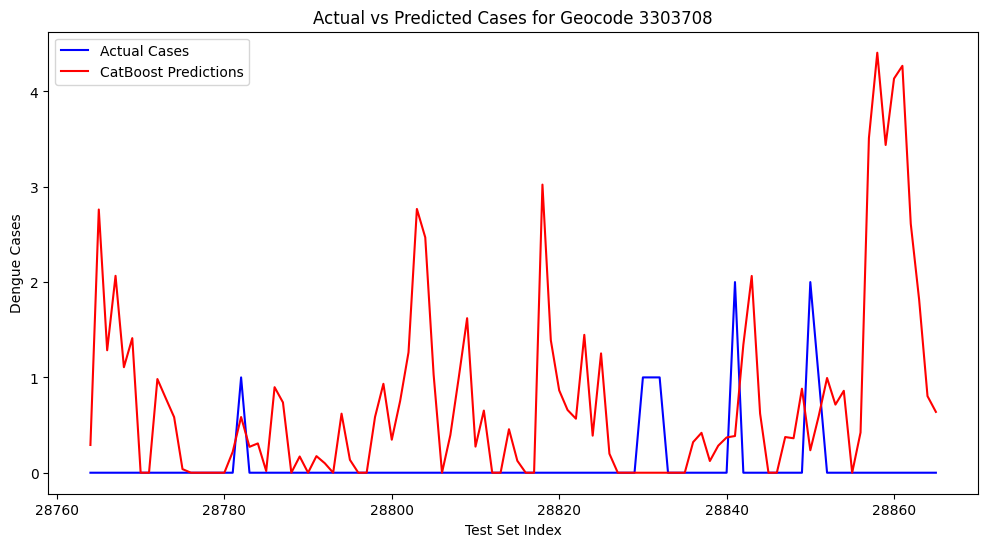

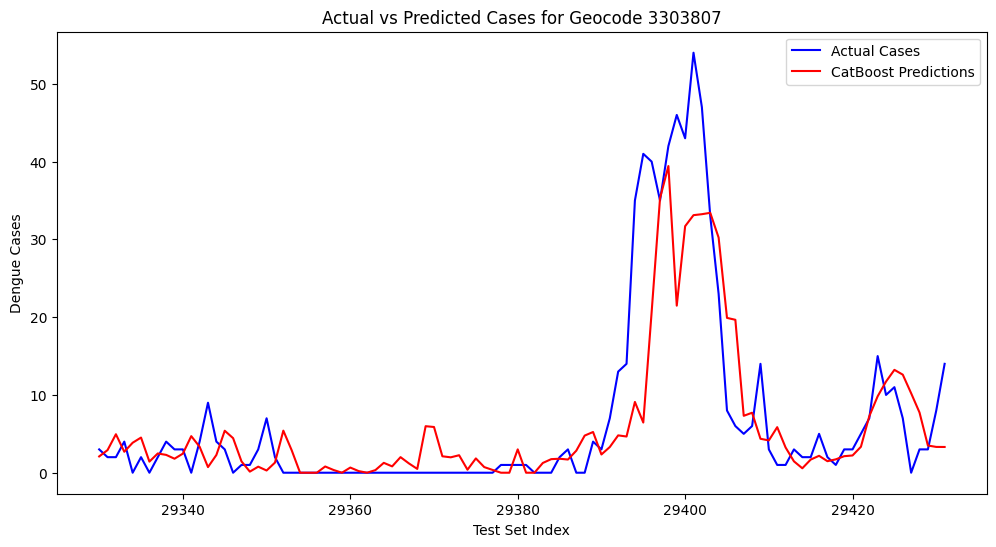

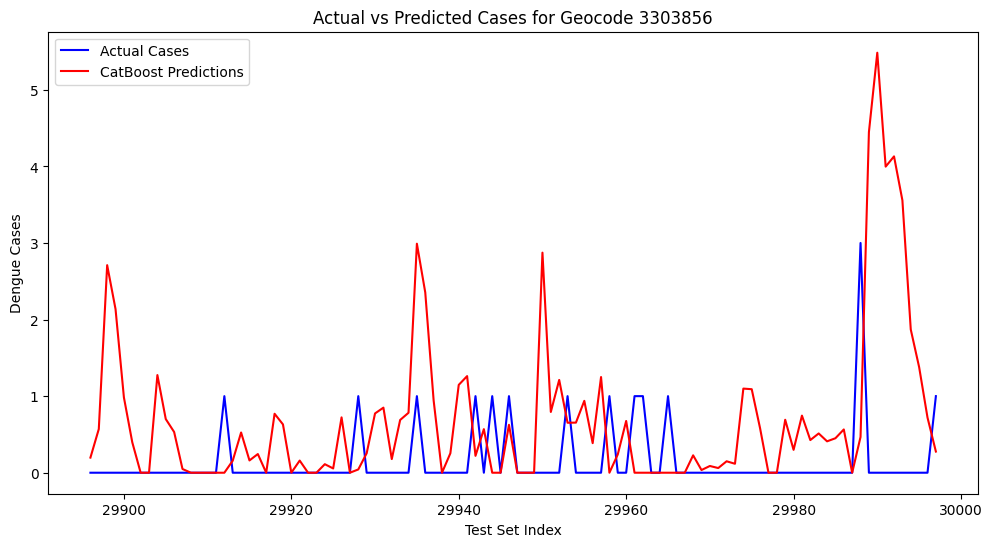

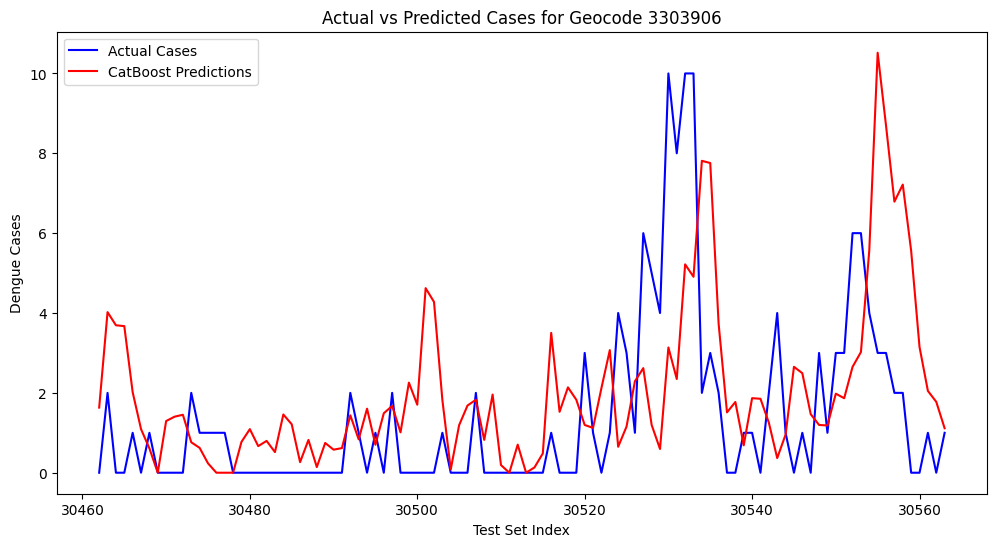

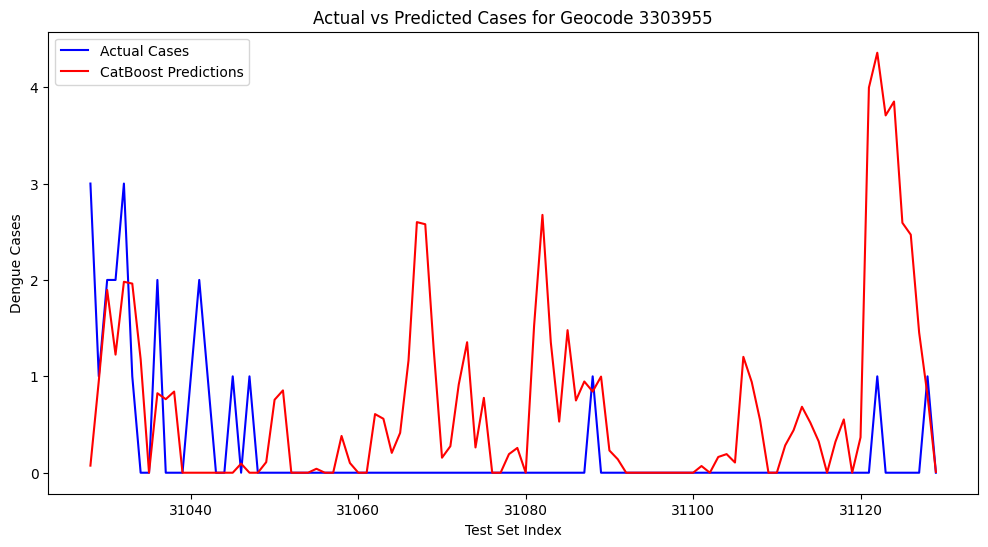

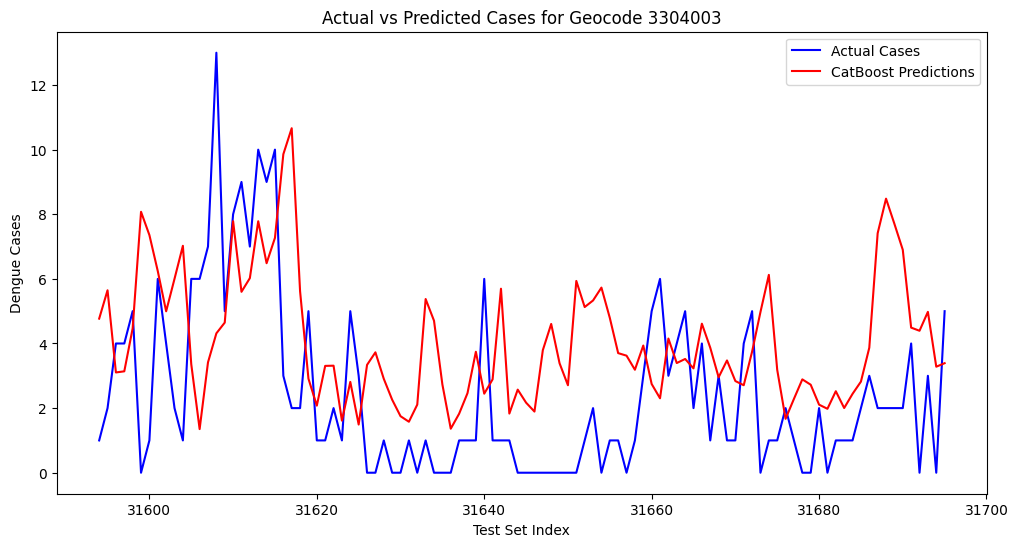

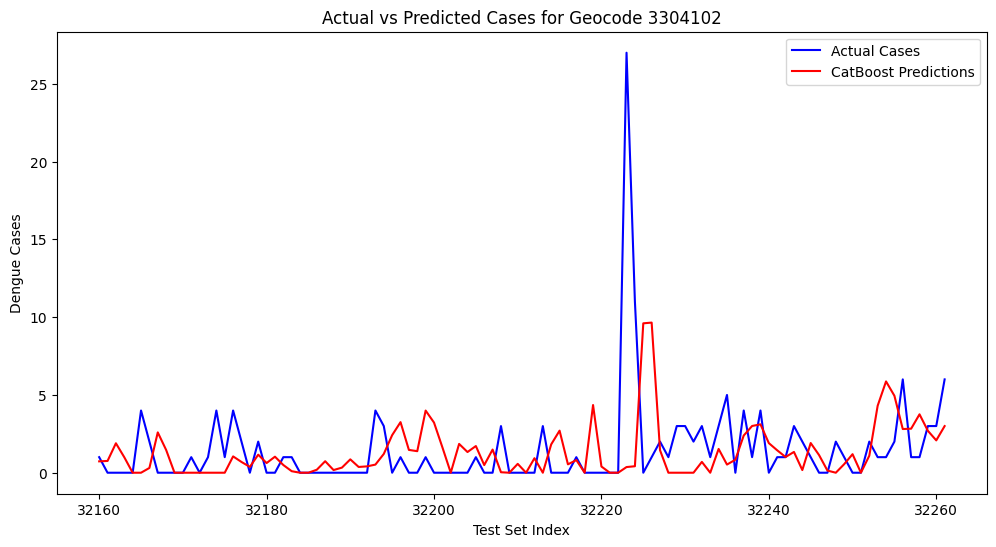

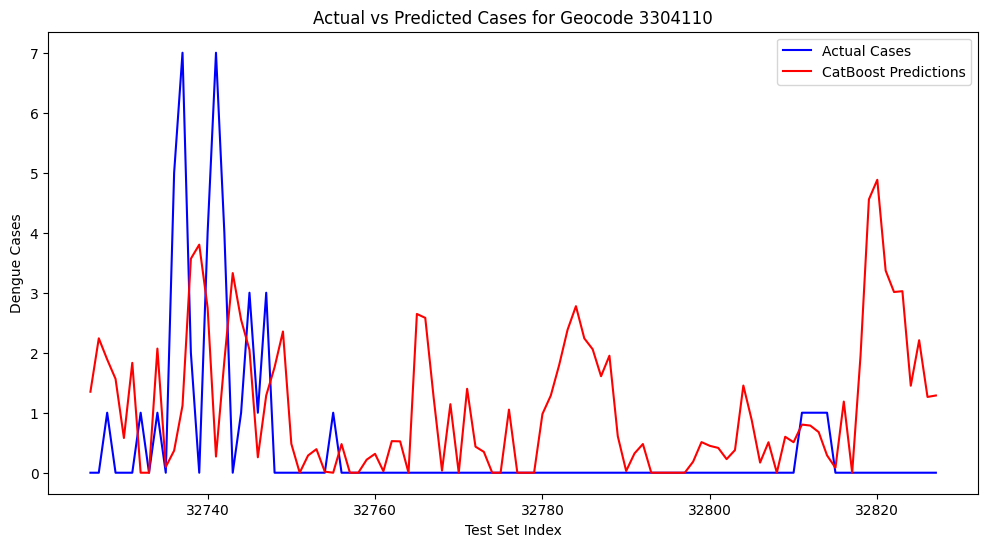

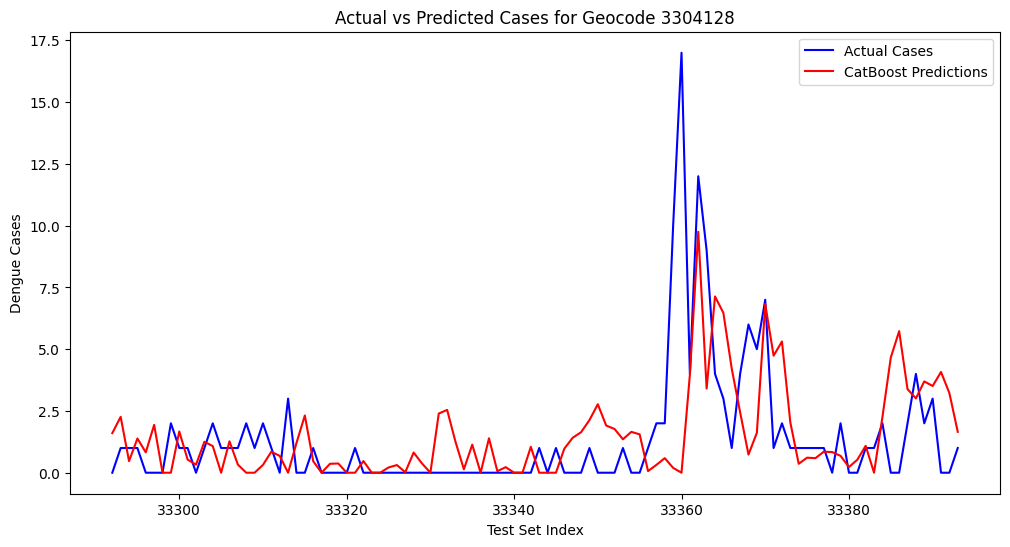

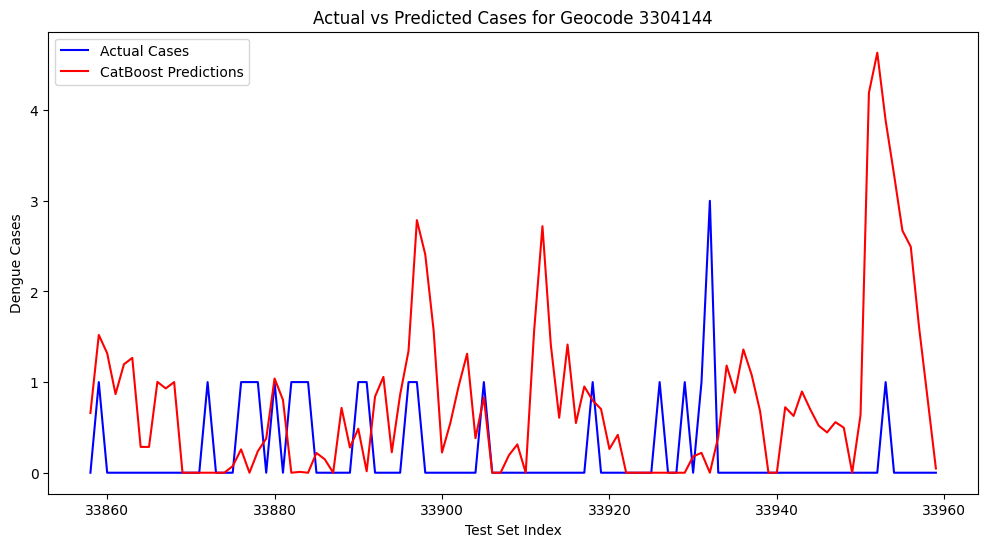

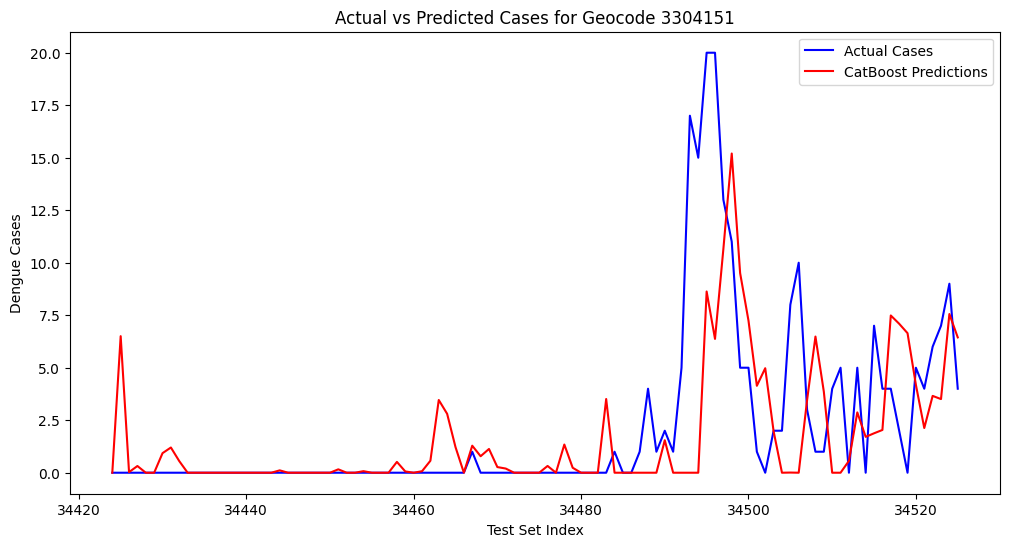

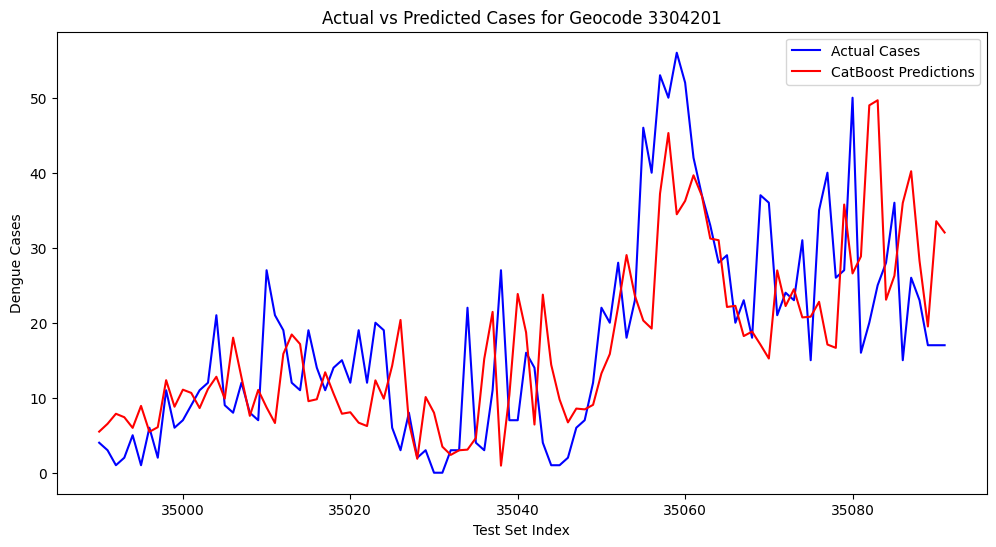

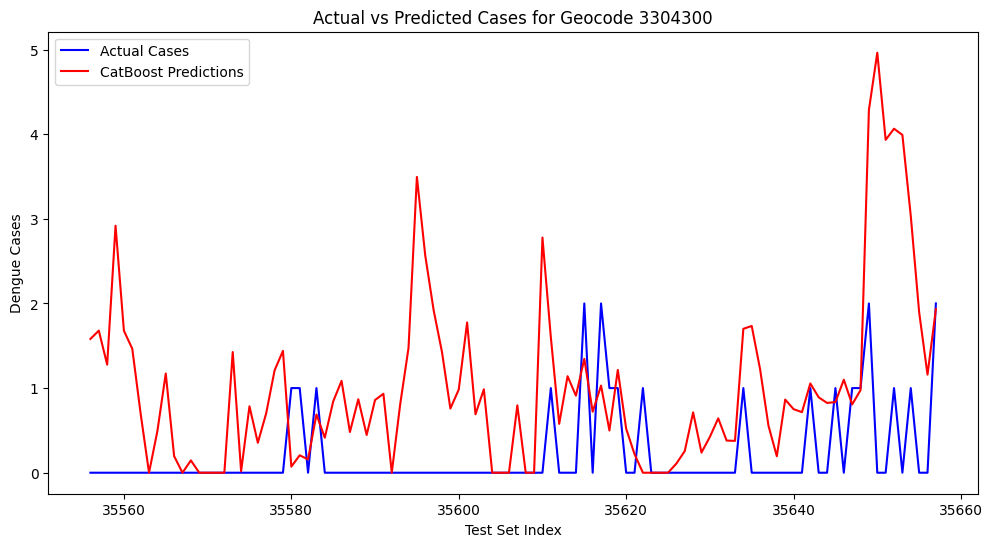

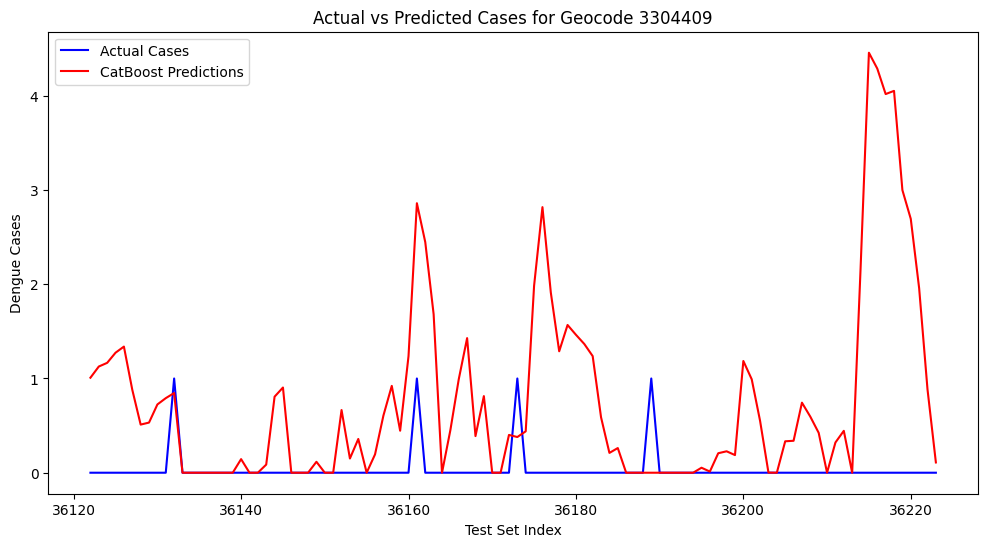

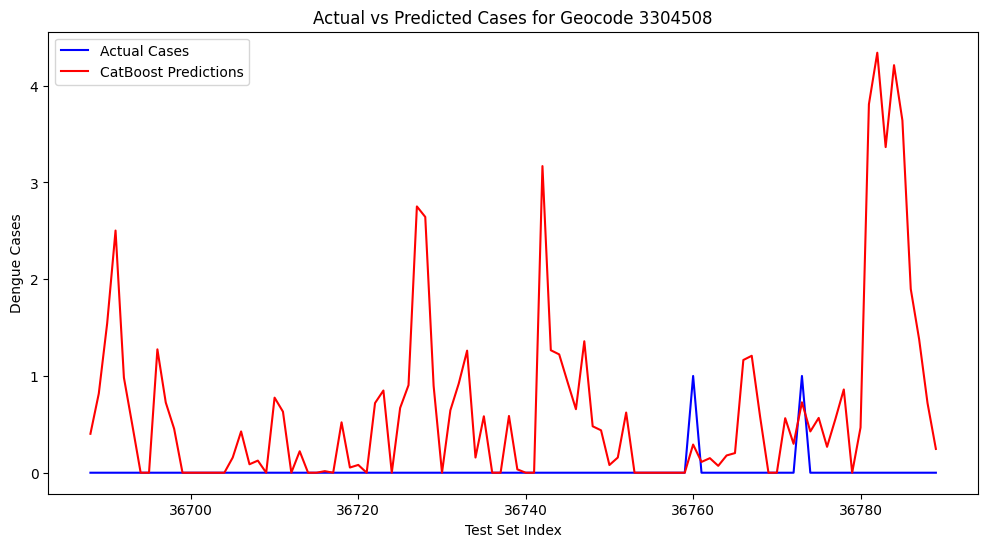

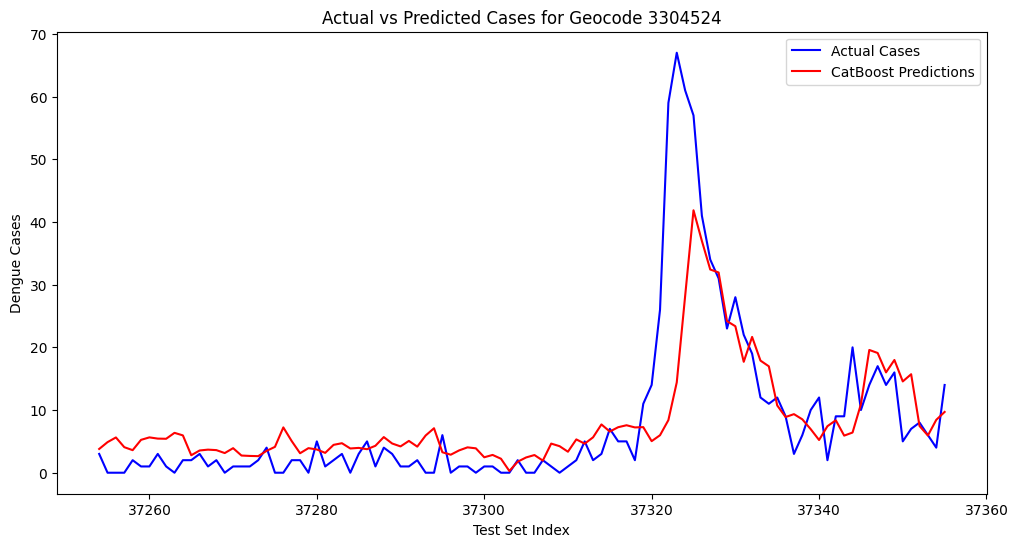

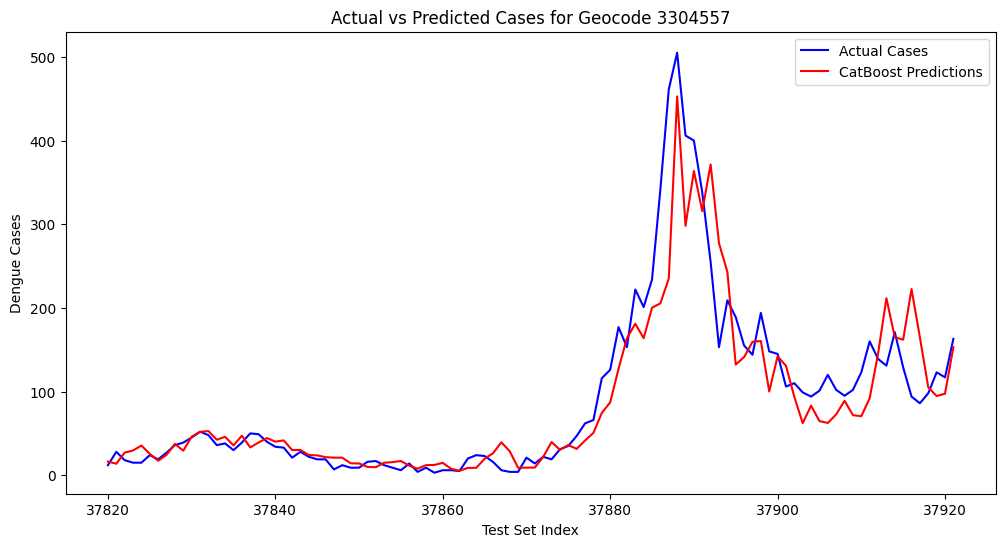

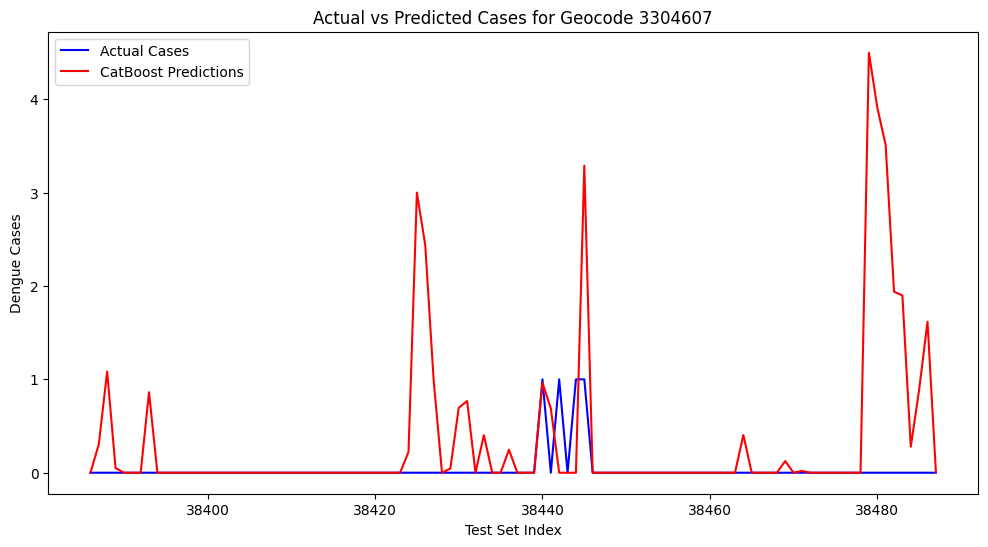

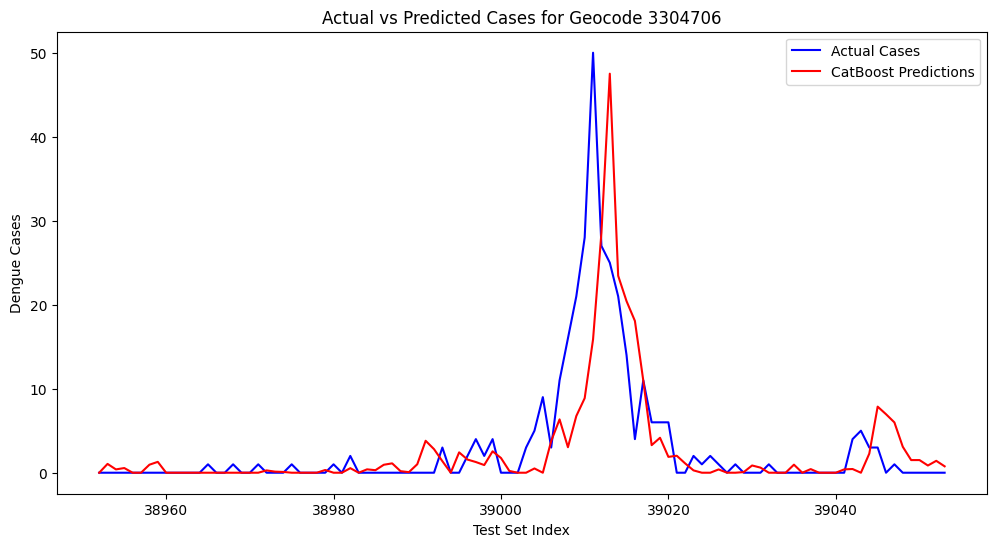

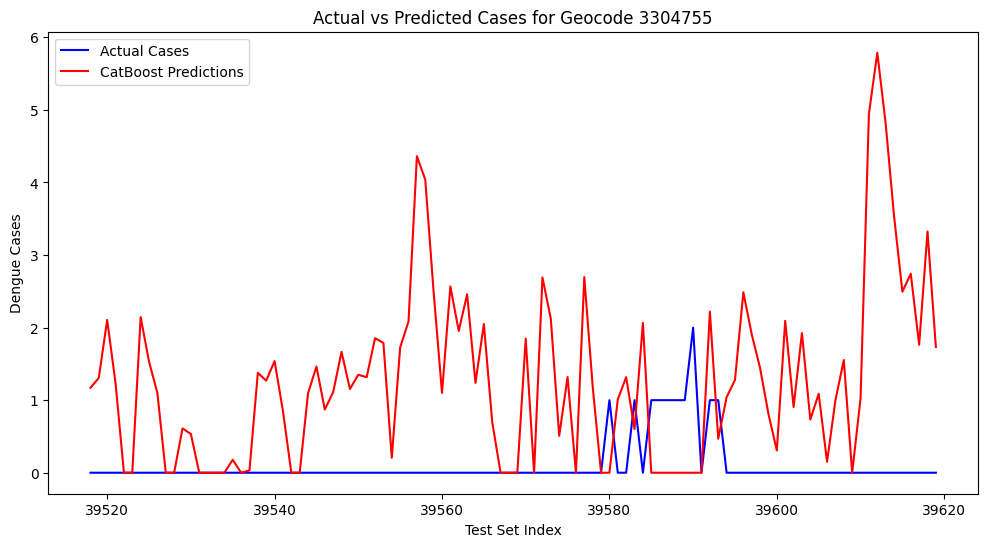

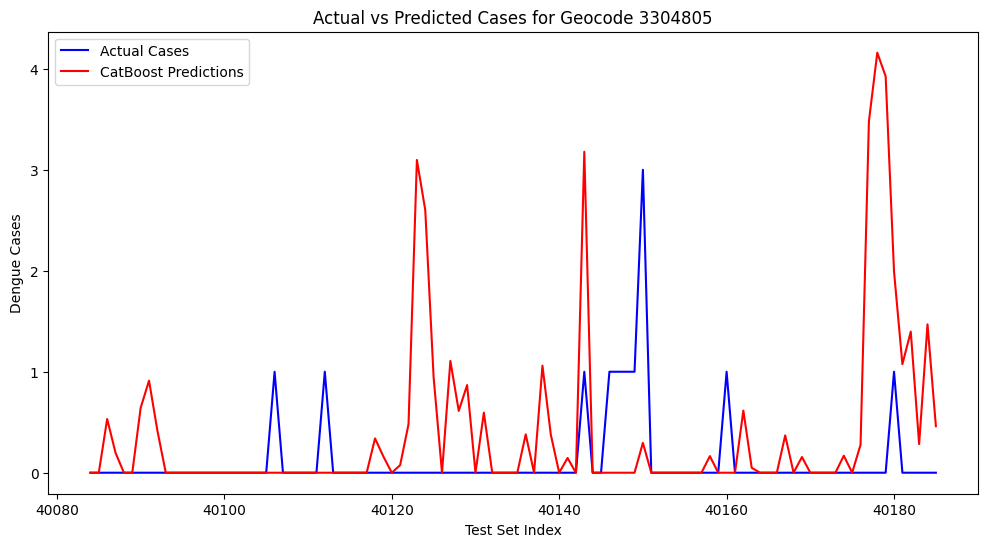

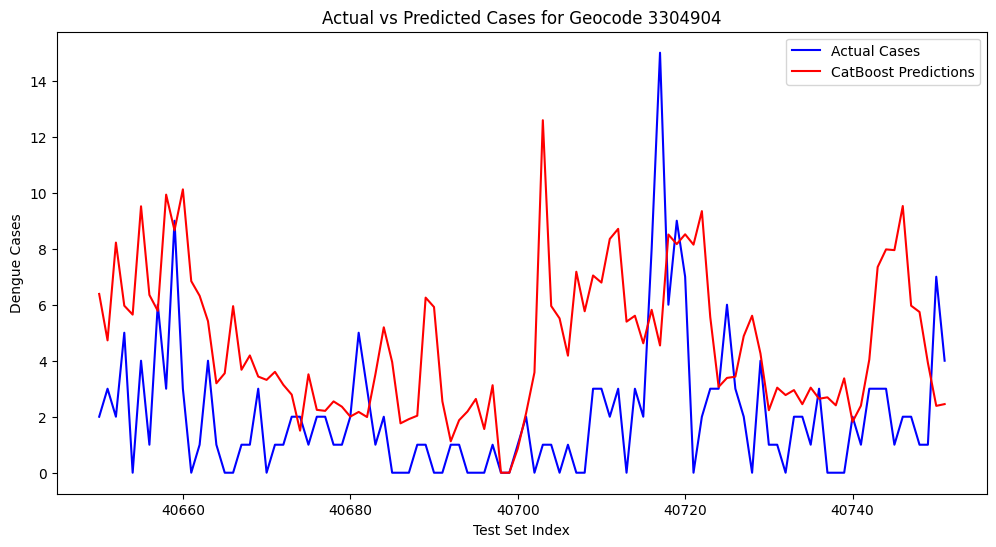

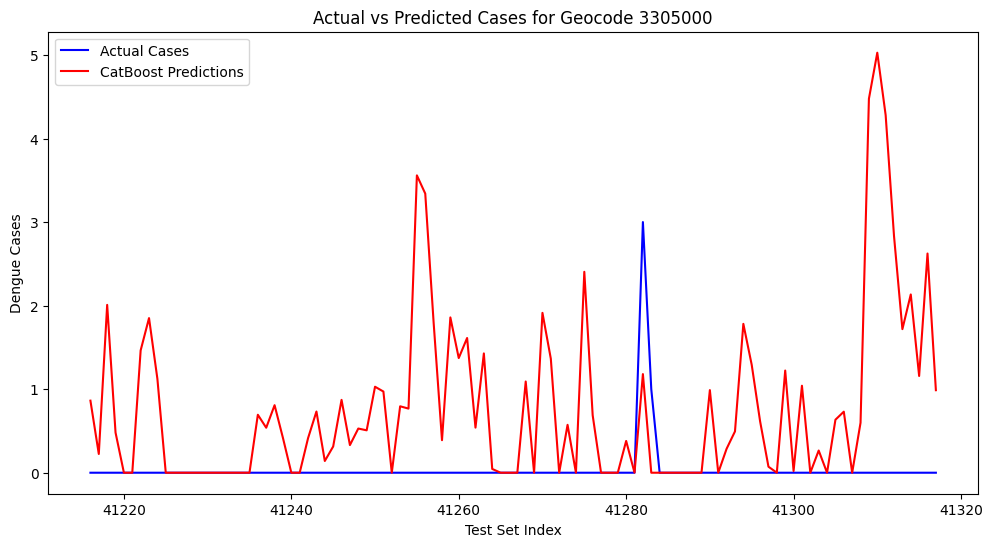

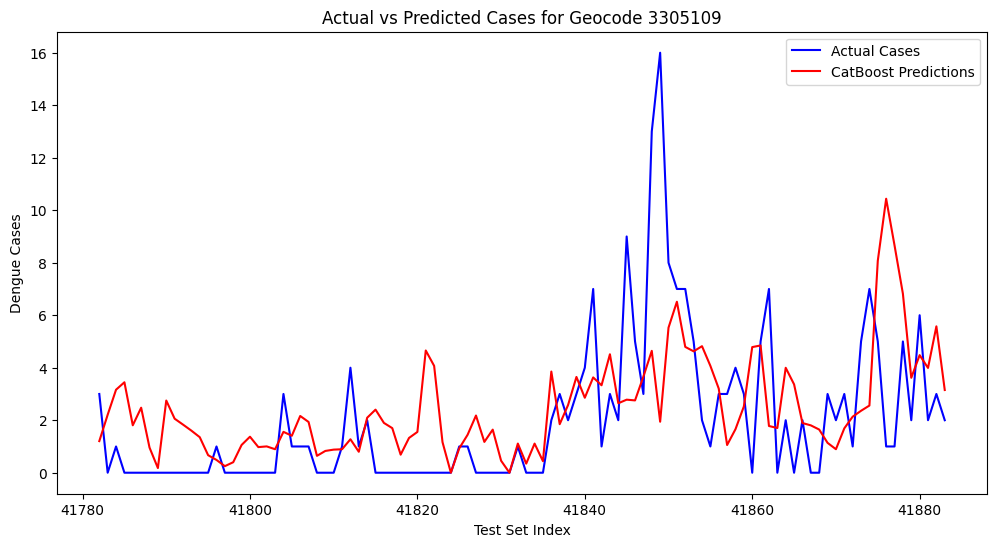

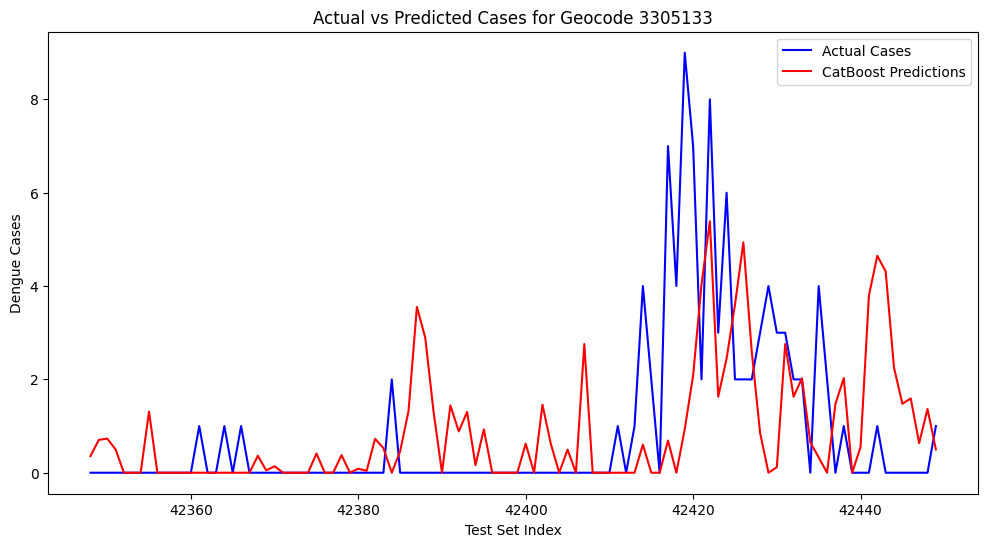

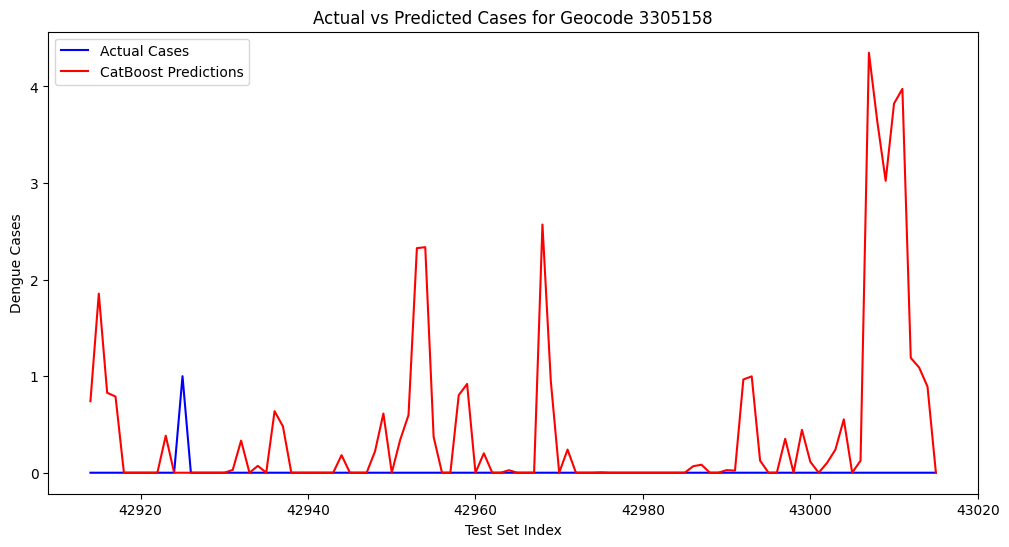

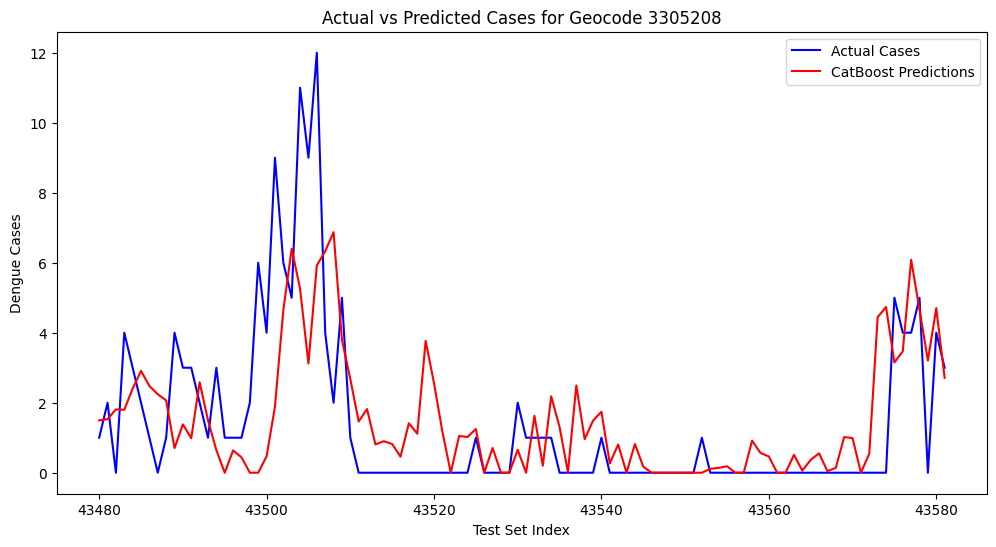

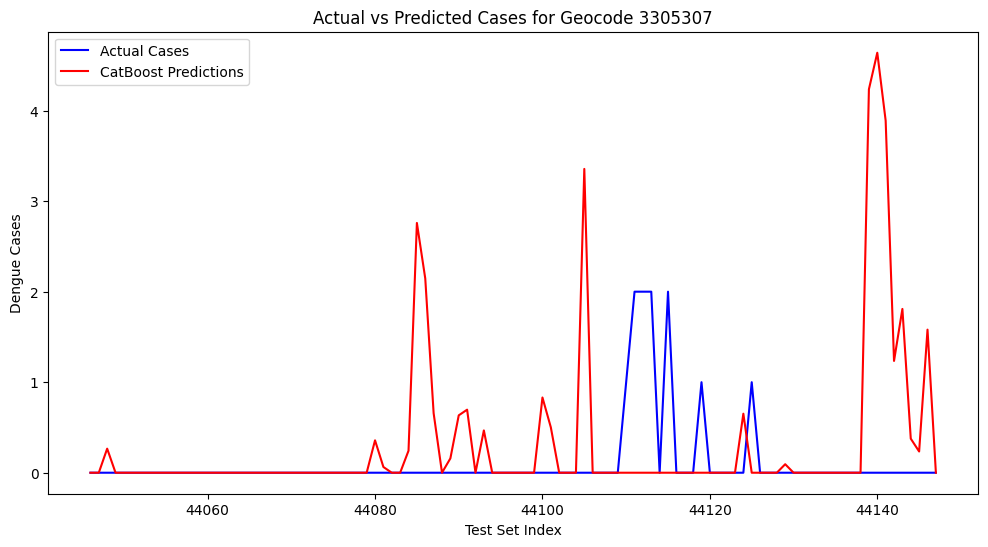

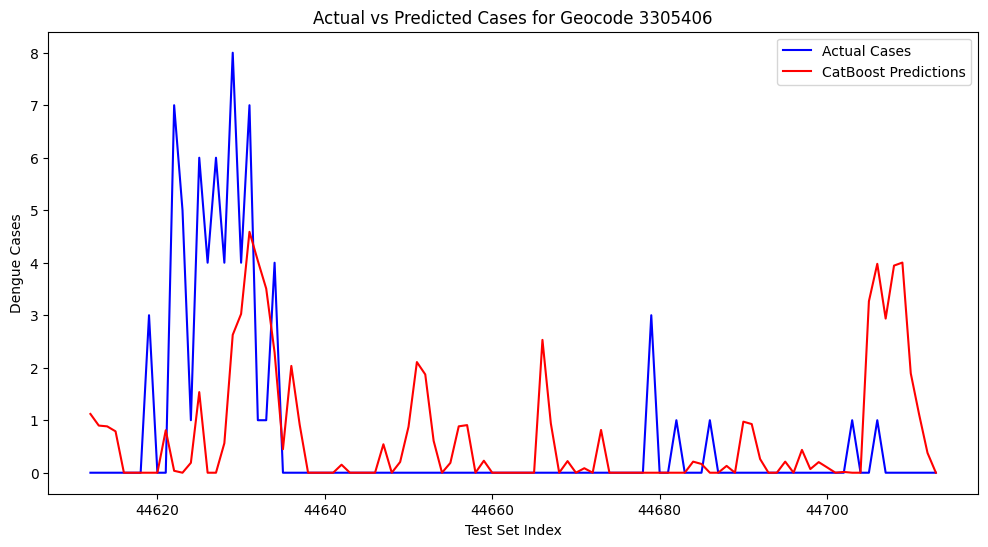

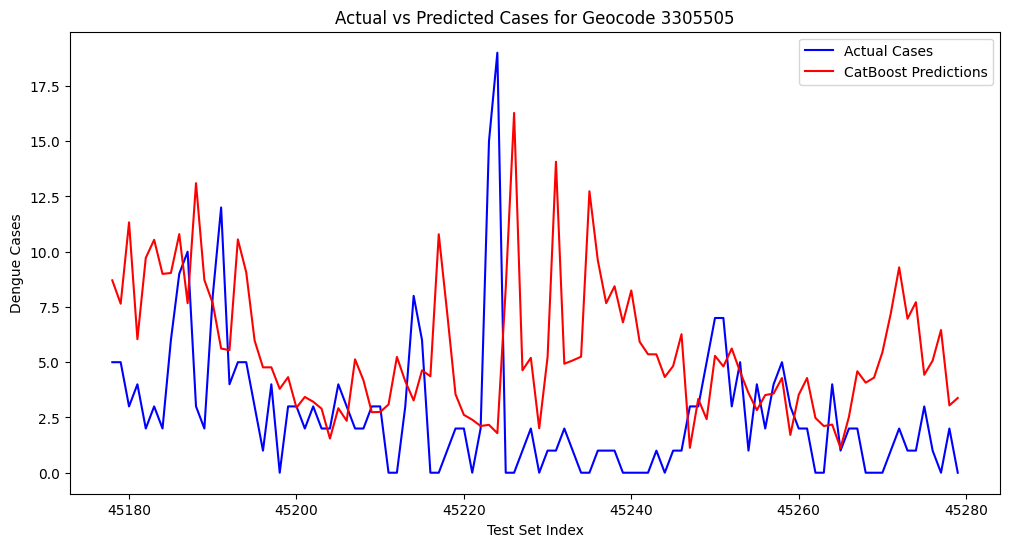

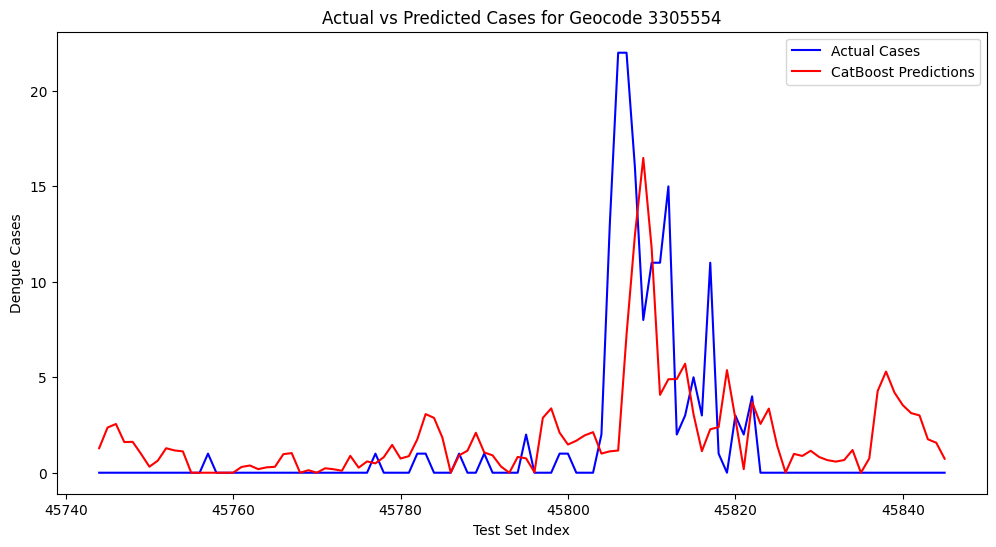

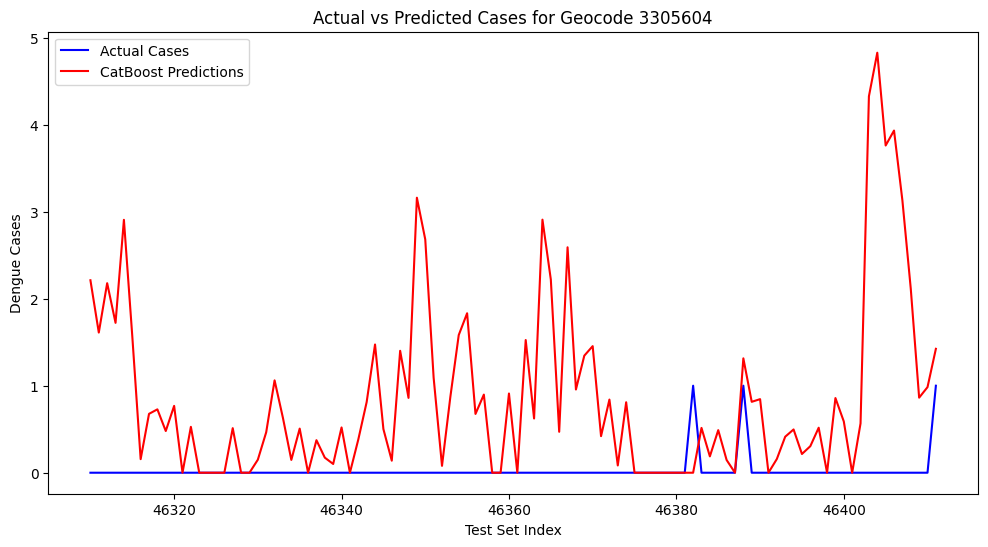

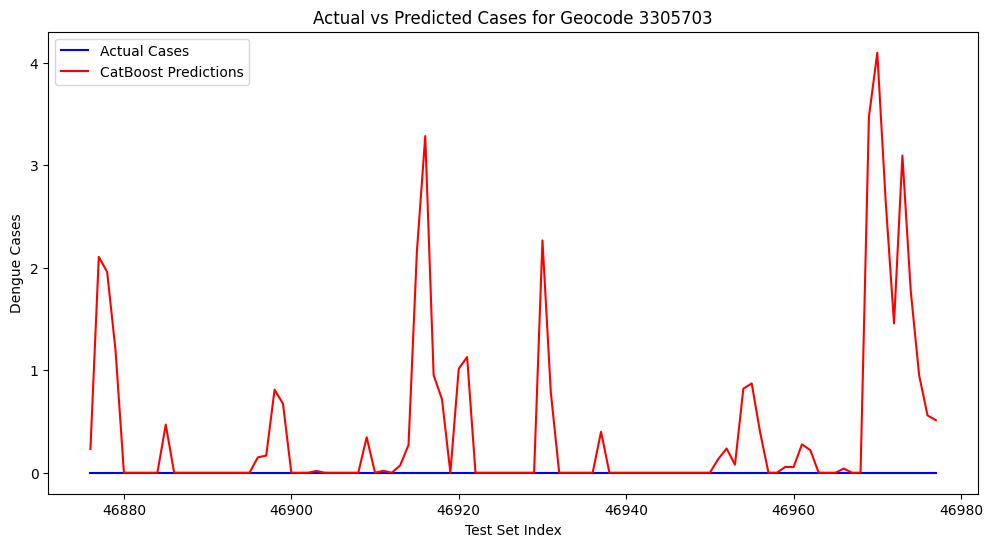

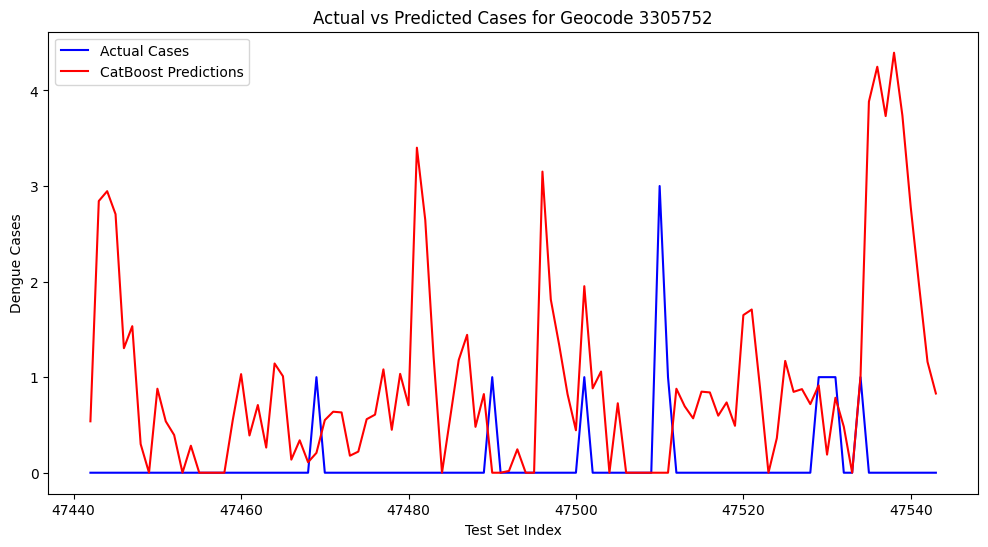

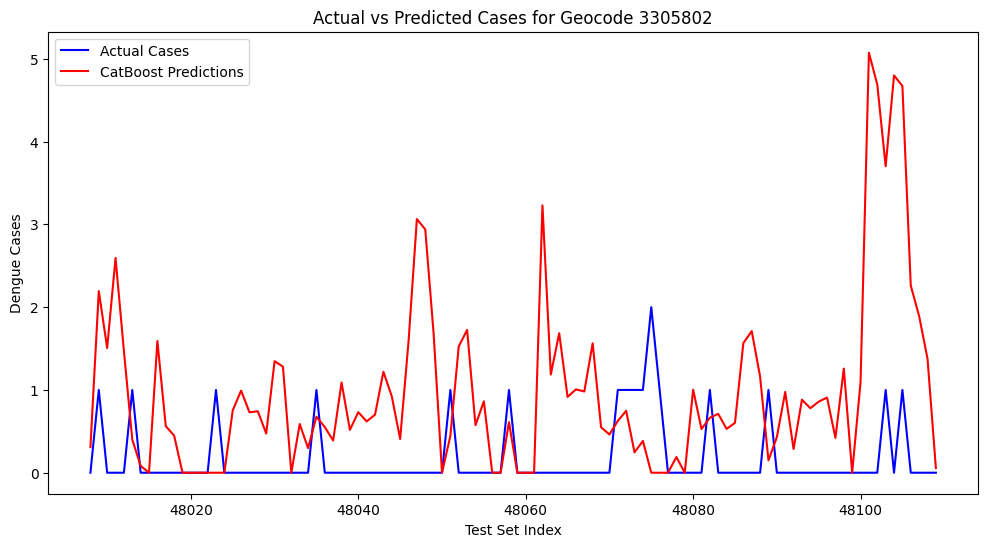

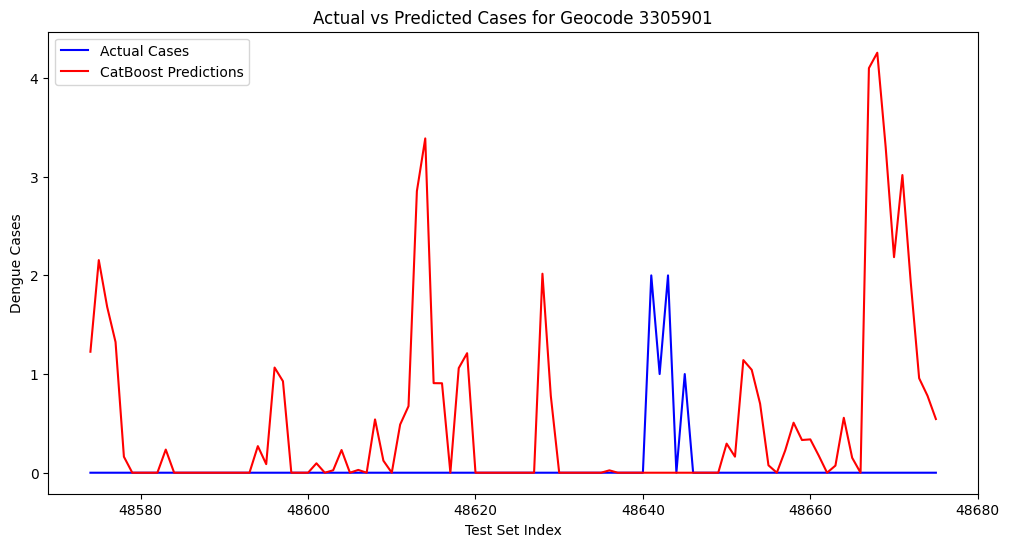

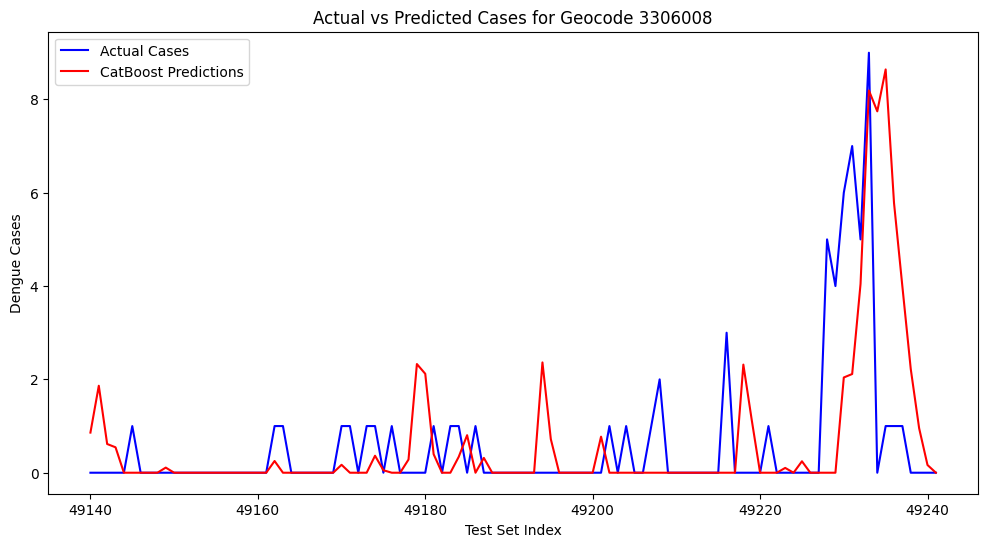

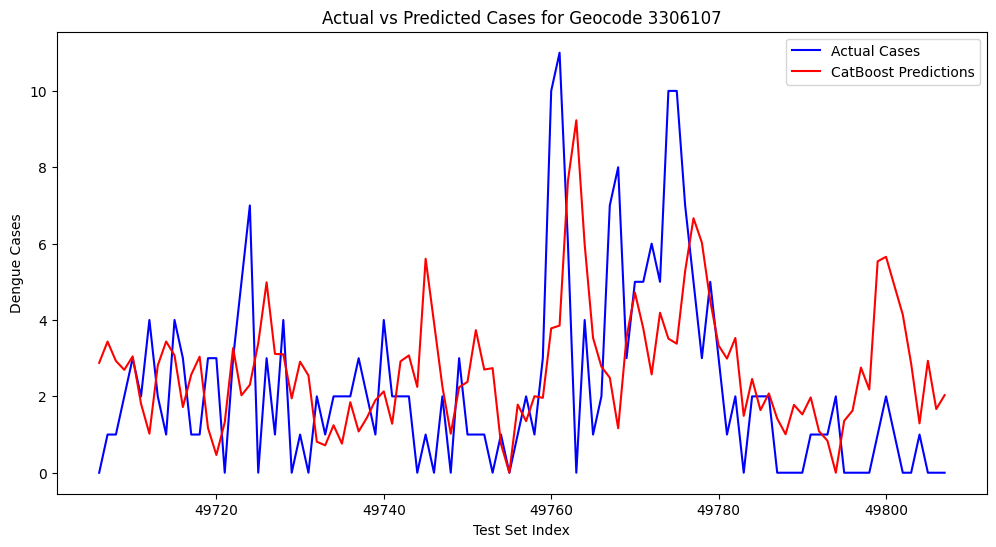

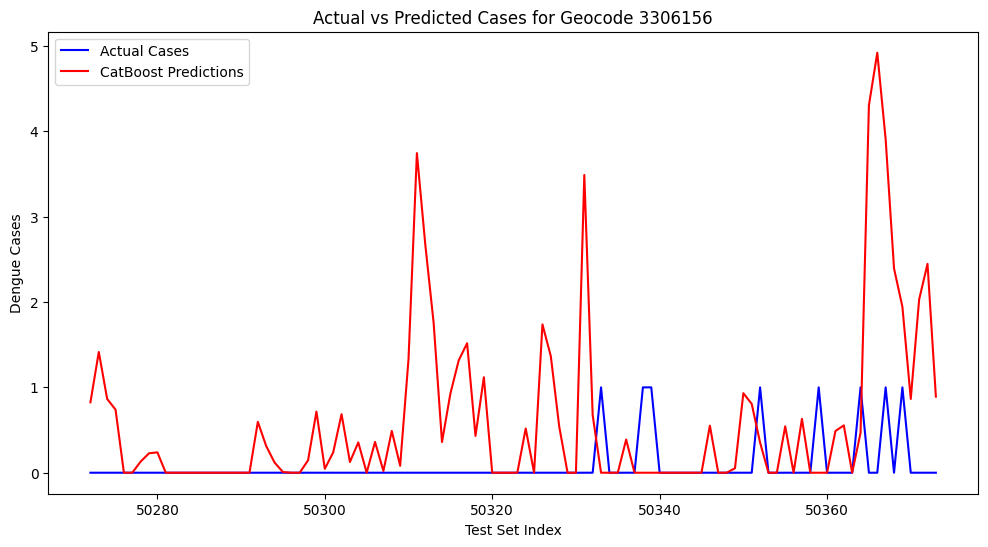

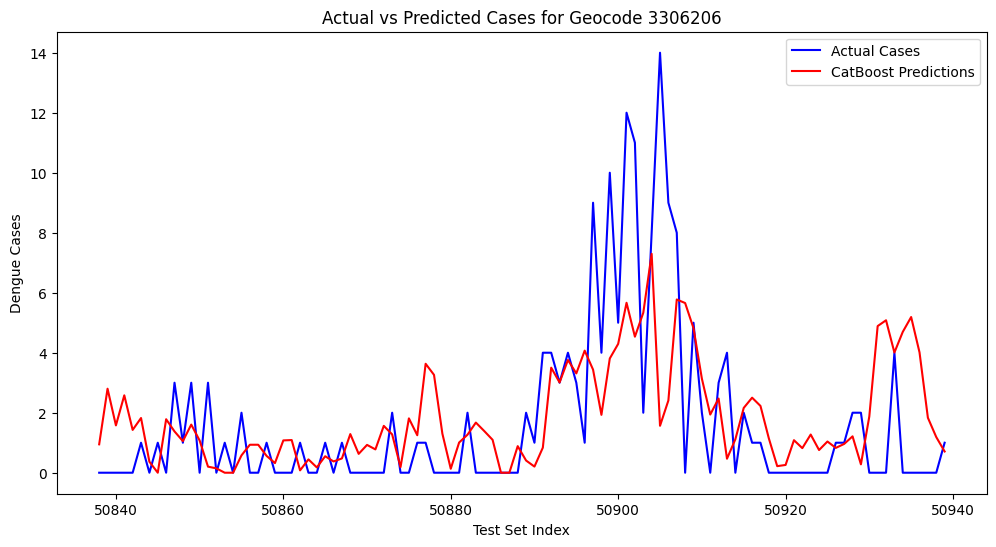

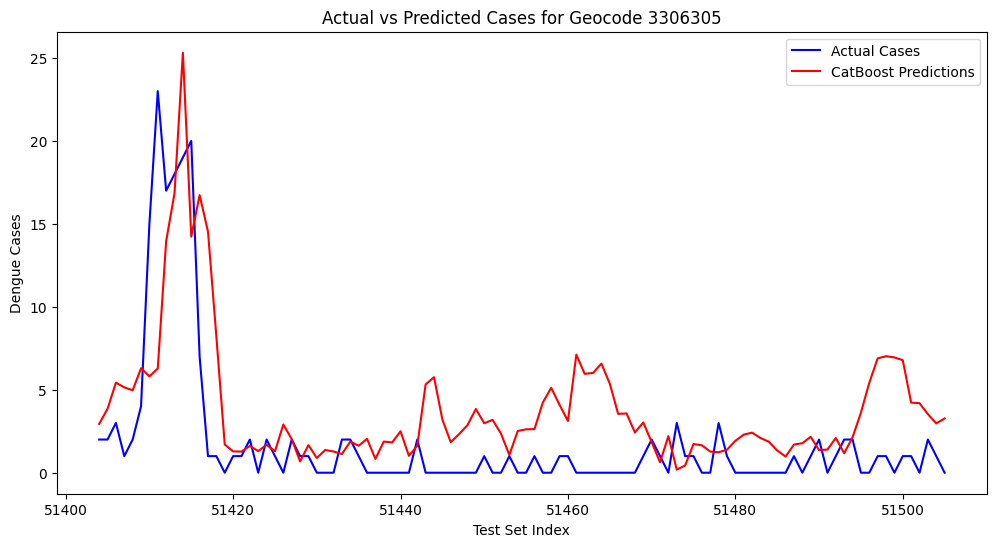

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor

# Step 1: Define columns that should not be scaled
columns_not_to_scale = ['week_sin', 'week_cos', 'month_sin', 'month_cos', 'week', 'lat', 'long', 
                        'geocode', 'year_sin', 'year_cos']

# Step 2: Define selected features
selected_columns = [
    'cases_lag0', 'cases_lag1', 'geocode',
    'temp_avg_lag4', 'humidity_avg_lag4',
    'precipitation_max_regression_kriging_lag4',
    'week_sin', 'month_sin', 'week_cos', 'month_cos',
    'year_sin', 'year_cos', 'nearby_cases_weighted', 'lat', 'long'
]

# Step 3: Select features
X_train = X_train[selected_columns]
X_test = X_test[selected_columns]

# Step 4: Scale numerical features
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

numeric_features = [col for col in X_train.columns if X_train[col].dtype in ['float64', 'int64', 'float32', 'int32'] 
                    and col not in columns_not_to_scale]

X_train[numeric_features] = feature_scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = feature_scaler.transform(X_test[numeric_features])

# Step 5: Scale target variables
y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)

y_train_scaled = target_scaler.fit_transform(y_train_reshaped).ravel()
y_test_scaled = target_scaler.transform(y_test_reshaped).ravel()

# Step 6: Define parameter grid for RandomizedSearchCV
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'bagging_temperature': [0, 1, 5, 10],
    'random_strength': [1, 5, 10],
    'border_count': [32, 64, 128],
    'boosting_type': ['Ordered', 'Plain'],
    'early_stopping_rounds': [50, 100],
    'verbose': [100]
}

# Step 7: Initialize CatBoost model
catboost_model = CatBoostRegressor(loss_function='RMSE', cat_features=['geocode'])

# Step 8: Hyperparameter tuning using RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X_train, y_train_scaled)

# Step 9: Retrieve best model and parameters
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Step 10: Make predictions using best model
y_train_pred_cb_scaled = best_model.predict(X_train)
y_test_pred_cb_scaled = best_model.predict(X_test)

# Step 11: Inverse scaling
y_train_pred_cb = target_scaler.inverse_transform(y_train_pred_cb_scaled.reshape(-1, 1)).ravel()
y_train_pred_cb = np.clip(y_train_pred_cb, 0, None)

y_test_pred_cb = target_scaler.inverse_transform(y_test_pred_cb_scaled.reshape(-1, 1)).ravel()
y_test_pred_cb = np.clip(y_test_pred_cb, 0, None)

# Step 12: Evaluate performance
train_rmse_cb = np.sqrt(mean_squared_error(y_train, y_train_pred_cb))
test_rmse_cb = np.sqrt(mean_squared_error(y_test, y_test_pred_cb))
train_r2_cb = r2_score(y_train, y_train_pred_cb)
test_r2_cb = r2_score(y_test, y_test_pred_cb)

print("\nCatBoost Model Performance:")
print("CatBoost RMSE (Train):", train_rmse_cb)
print("CatBoost RMSE (Test):", test_rmse_cb)
print("CatBoost R² (Train):", train_r2_cb)
print("CatBoost R² (Test):", test_r2_cb)

# Step 13: Feature Importance
importance_cb = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_model.feature_importances_})
importance_cb = importance_cb.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(importance_cb['Feature'], importance_cb['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in CatBoost Model")
plt.gca().invert_yaxis()
plt.show()

# Step 14: Visualization - Actual vs Predicted per Geocode
unique_geocodes = X_test['geocode'].unique()

for geocode in unique_geocodes:
    geocode_mask = X_test['geocode'] == geocode
    y_test_geocode = y_test[geocode_mask]
    y_test_pred_cb_geocode = y_test_pred_cb[geocode_mask]
    
    indices = X_test[geocode_mask].index
    
    plt.figure(figsize=(12, 6))
    plt.plot(indices, y_test_geocode, label="Actual Cases", color='b')
    plt.plot(indices, y_test_pred_cb_geocode, label="CatBoost Predictions", color='r')
    plt.xlabel("Test Set Index")
    plt.ylabel("Dengue Cases")
    plt.title(f"Actual vs Predicted Cases for Geocode {geocode}")
    plt.legend()
    plt.show()


In [ ]:
# Create DataFrame for predictions with geocode
test_data_with_preds = test_data.copy()
test_data_with_preds = test_data_with_preds.reset_index(drop=True)

# Ensure geocode is string for consistency and sorting
test_data_with_preds['geocode'] = test_data_with_preds['geocode'].astype(str)

# Add predictions and actual values
test_data_with_preds['catboost_pred'] = y_test_pred_cb
test_data_with_preds['actual'] = y_test.values.ravel()

# Filter and save for 2021
catboost_preds_2021 = test_data_with_preds[test_data_with_preds['year'] == 2021][['geocode', 'catboost_pred', 'actual']]
catboost_preds_2021.to_csv('../base_predictions/catboost_preds.csv', index=False)

# Filter and save for 2022
catboost_preds_2022 = test_data_with_preds[test_data_with_preds['year'] == 2022][['geocode', 'catboost_pred', 'actual']]
catboost_preds_2022.to_csv('../base_predictions/catboost_test_preds.csv', index=False)

print("CatBoost prediction files saved: catboost_preds.csv and catboost_test_preds.csv")


CatBoost prediction files saved: catboost_preds.csv and catboost_test_preds.csv
